In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from numba import njit
from numba.typed import List
import numpy as np
from sklearn.cluster import SpectralClustering, KMeans
import seaborn as sns
from tqdm import tqdm

import make_clean_showers as mcs
import find_crab as fc
from apply_gains import apply_gains
import target_io
palette = ['#00263b', '#1e5563', '#568683', '#a0b795', '#ffe591', '#f89c58', '#d9612c', '#aa2c0f', '#6f0000']
sns.set_palette(palette)
sns.set_style("whitegrid")

In [3]:
@njit
def clean_image(raw_charge: np.ndarray, grid_ind: List, mean_noise: np.ndarray) -> np.ndarray:
    # constant values relating to the proportion of a square covered
    # by part of a circle
    a = 0.2138
    b = 0.479
    c = 0.985

    # corresponds to an aperture with 2 pxl radius
    aperture = [[0., a, b, a, 0.],
                [a, c, 1., c, a],
                [b, 1., 1., 1., b],
                [a, c, 1., c, a],
                [0., a, b, a, 0.]]
    aperture = np.asarray(aperture)
    charge_temp = np.zeros((40, 40))
    for i, val in enumerate(raw_charge):
        charge_temp[grid_ind[i] % 40, grid_ind[i] // 40] = val

    # charge = np.pad(charge, (2,), constant_values=(0,)
    charge = np.zeros((44, 44))
    charge[2:42, 2:42] = charge_temp

    image = np.zeros((40, 40))
    for i in range(40):
        for j in range(40):
            if charge[i+2, j+2] == 0.0:
                image[j, i] = np.NaN
                continue
            s = np.nansum(charge[i:i+5, j:j+5] * aperture)
            #if s / mean_noise[j, i] > 50:
            if s > 150.0:
                image[j, i] = charge[i+2, j+2]

    return image

In [4]:
%matplotlib inline
def camera_image(image, run, ev, keep=False):
    maxZ = np.nanmax(image)
    fig = plt.gcf()
    if fig.get_size_inches().all() == np.array([18., 15.]).all():
        plt.close(fig)
        fig = plt.figure(figsize=(18, 15))
    gs = gridspec.GridSpec(5, 5)
    gs.update(wspace=0.04, hspace=0.04)

    for i in range(5):
        for j in range(5):
            sub_image = image[i*8:i*8+8, j*8:j*8+8]
            ax = plt.subplot(gs[4 - i, j])
            c = ax.pcolormesh(sub_image, vmin=0, vmax=maxZ, cmap="viridis")
            ax.axis("off")
            ax.set_aspect("equal")

    fig.subplots_adjust(right=0.8, top=0.9, bottom=0.1)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = fig.colorbar(c, cax=cbar_ax)
    cbar.set_label("Charge (Photoelectrons)", rotation=270,
                   size=24, labelpad=24)
    cbar_ax.tick_params(labelsize=20)
    fig.suptitle(f"Run {run} Event {ev}", fontsize=30)

In [5]:
mod_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 100, 103, 106, 107,
            108, 111, 112, 114, 115, 119, 121, 123, 124, 125, 126]

mod_nums = [100, 111, 114, 107, 6, 115, 123, 124, 112, 7, 119,
            108, 110, 121, 8, 103, 125, 126, 106, 9, 4, 5, 1, 3, 2]
fpm_nums = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24]

fpm_pos = np.mgrid[0:5, 0:5]
fpm_pos = zip(fpm_pos[0].flatten(), fpm_pos[1].flatten())

mod_to_fpm = dict(zip(mod_nums, fpm_nums))
fpm_to_pos = dict(zip(fpm_nums, fpm_pos))

ch_nums = np.array([[21, 20, 17, 16, 5, 4, 1, 0],
                    [23, 22, 19, 18, 7, 6, 3, 2],
                    [29, 28, 25, 24, 13, 12, 9, 8],
                    [31, 30, 27, 26, 15, 14, 11, 10],
                    [53, 52, 49, 48, 37, 36, 33, 32],
                    [55, 54, 51, 50, 39, 38, 35, 34],
                    [61, 60, 57, 56, 45, 44, 41, 40],
                    [63, 62, 59, 58, 47, 46, 43, 42]])
rot_ch_nums = np.rot90(ch_nums, k=2)
ch_to_pos = dict(zip(ch_nums.reshape(-1), np.arange(64)))
rot_ch_to_pos = dict(zip(rot_ch_nums.reshape(-1), np.arange(64)))

num_columns = 5
total_cells = num_columns * num_columns * 64
indices = np.arange(total_cells).reshape(-1, int(np.sqrt(total_cells)))
grid_ind = List()
for index, mod in enumerate(mod_list):
    i, j = fpm_to_pos[mod_to_fpm[mod]]
    ch_map = dict()
    if j % 2 == 0:
        ch_map = rot_ch_to_pos
    else:
        ch_map = ch_to_pos
    # print(f"Channel Map: {ch_map}")
    j = num_columns - 1 - j
    pix_ind = np.array(indices[
        (8*i):8*(i+1), (8*j):8*(j+1)]).reshape(-1)
    # print(f"Pixel Index: {pix_ind}")
    for asic in range(4):
        for ch in range(16):
            grid_ind.append(int(pix_ind[
                ch_map[asic * 16 + ch]]))

In [6]:
DATADIR = "/data/user/bmode/crab_data/v0.2"
all_data = []
runs = [328629, 328630, 328631]
for run in runs:
    temp = np.loadtxt(f"{DATADIR}/on_data_run{run}.txt", skiprows=1, delimiter=", ")
    if run == 328631:
        temp = [line for line in temp if line[1] < 122804]
    all_data.extend(temp)
all_data = np.asarray(all_data)
all_data = all_data.T
data = {"run": all_data[0],
        "event": all_data[1],
        "tack": all_data[4],
        "size": all_data[5],
        "frac2": all_data[6],
        "x": all_data[7],
        "y": all_data[8],
        "width": all_data[9],
        "length": all_data[10],
        "dis": all_data[12],
        "alpha": all_data[14]}

Text(0.5, 1.0, 'Coast to Coast Data')

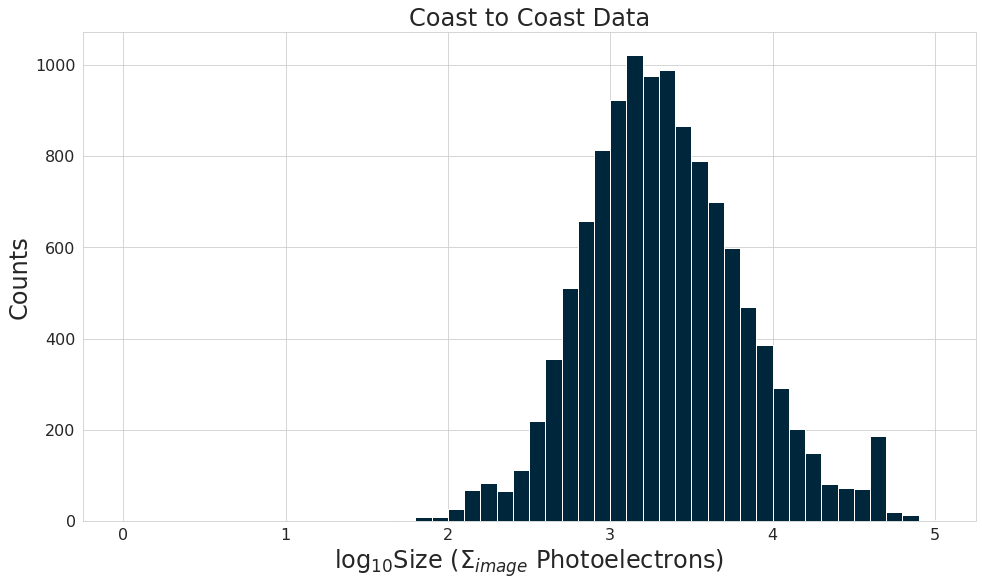

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.hist(np.log10(data["size"]), bins=50, range=(0, 5))
ax.set_xlabel(r"$\log_{10}$Size ($\Sigma_{image}$ Photoelectrons)", fontsize=24)
ax.set_ylabel("Counts", fontsize=24)
ax.tick_params(labelsize=16)
ax.set_title("Coast to Coast Data", fontsize=24)

Text(0.5, 1.0, 'Coast to Coast Data')

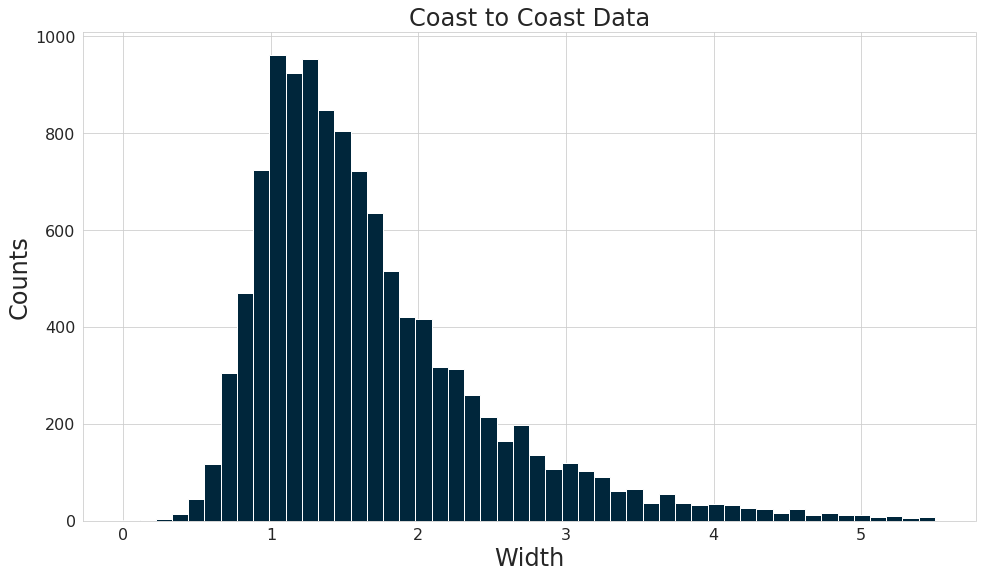

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.hist(data["width"], bins=50, range=(0, 5.5))
ax.set_xlabel("Width", fontsize=24)
ax.set_ylabel("Counts", fontsize=24)
ax.tick_params(labelsize=16)
ax.set_title("Coast to Coast Data", fontsize=24)

Text(0.5, 1.0, 'Coast to Coast Data')

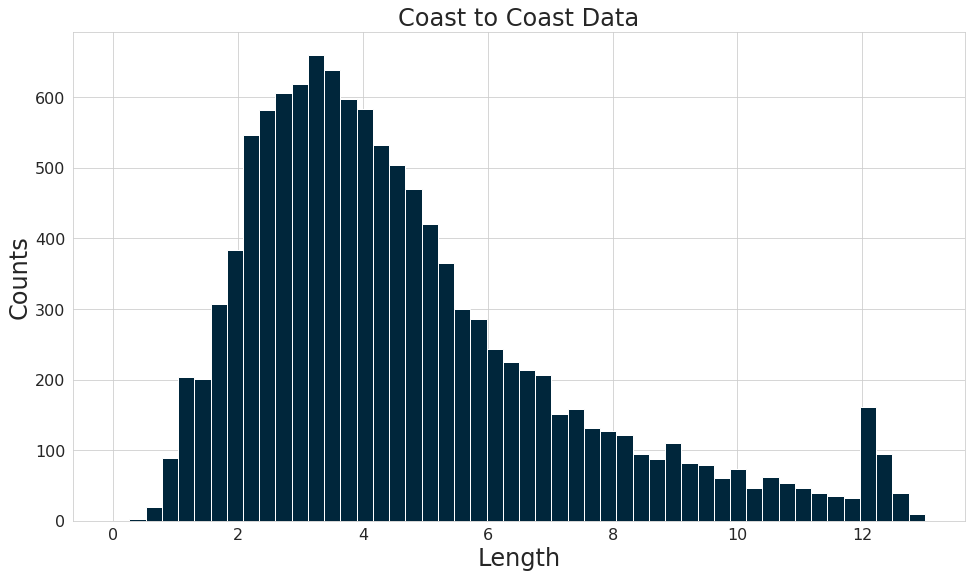

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.hist(data["length"], bins=50, range=(0, 13))
ax.set_xlabel("Length", fontsize=24)
ax.set_ylabel("Counts", fontsize=24)
ax.tick_params(labelsize=16)
ax.set_title("Coast to Coast Data", fontsize=24)

Text(0.5, 1.0, 'Coast to Coast Data')

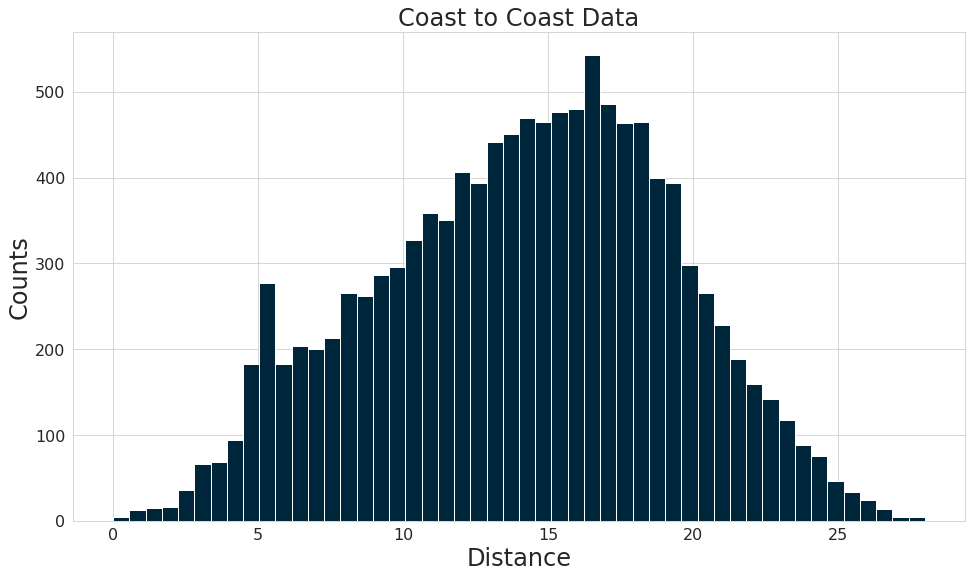

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.hist(data["dis"], bins=50, range=(0, 28))
ax.set_xlabel("Distance", fontsize=24)
ax.set_ylabel("Counts", fontsize=24)
ax.tick_params(labelsize=16)
ax.set_title("Coast to Coast Data", fontsize=24)

Text(0.5, 1.0, 'Coast to Coast Data')

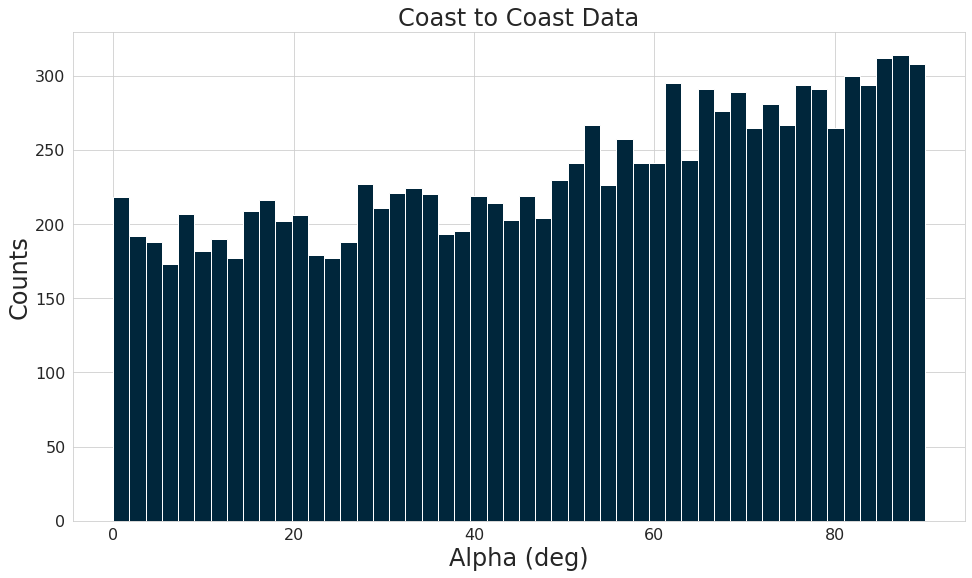

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.hist(np.degrees(data["alpha"]), bins=50, range=(0, 90))
ax.set_xlabel("Alpha (deg)", fontsize=24)
ax.set_ylabel("Counts", fontsize=24)
ax.tick_params(labelsize=16)
ax.set_title("Coast to Coast Data", fontsize=24)

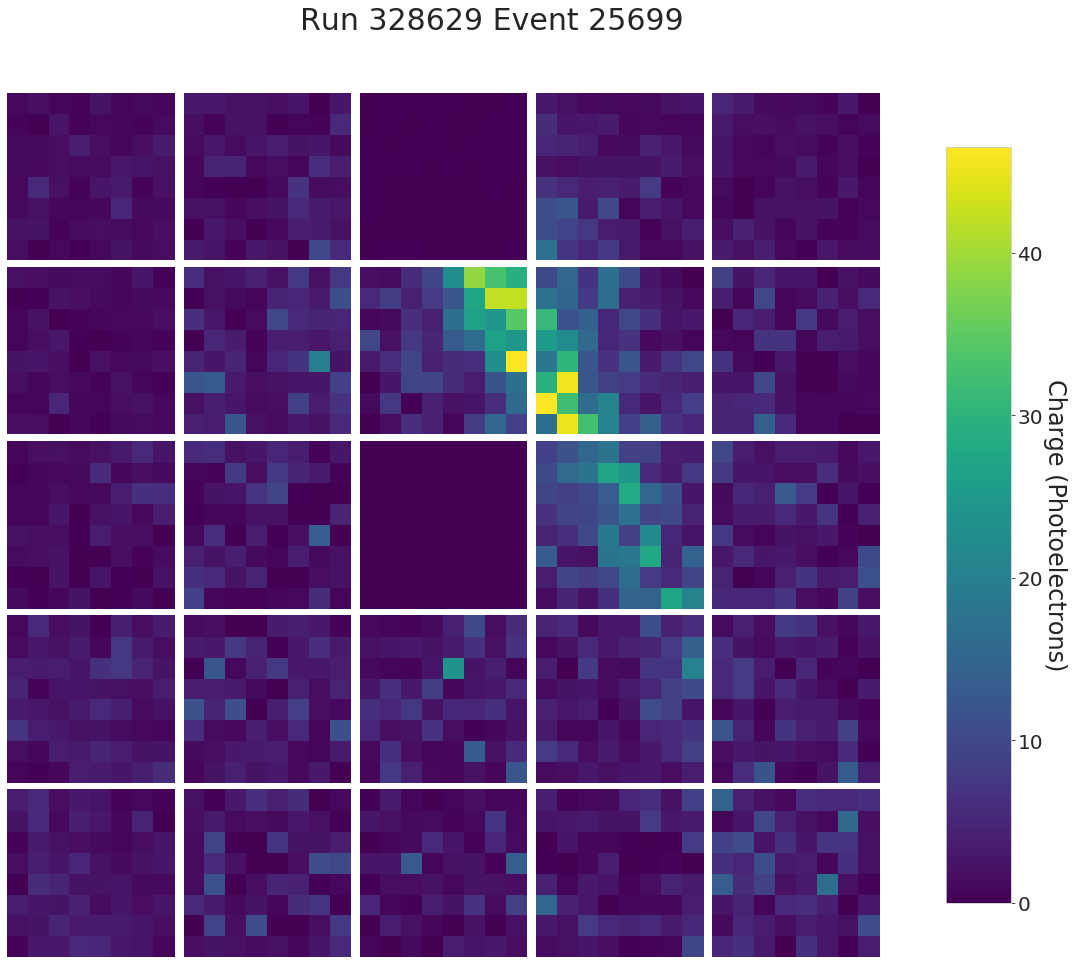

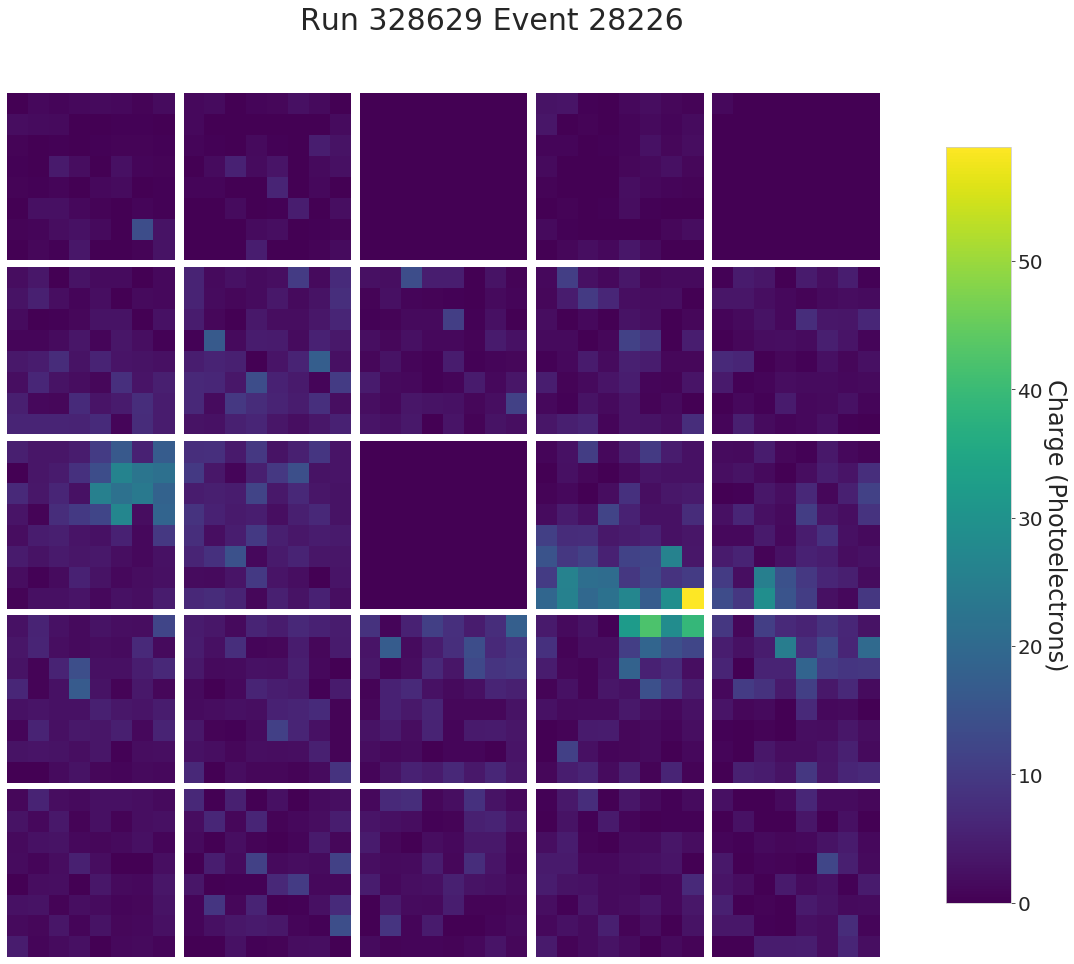

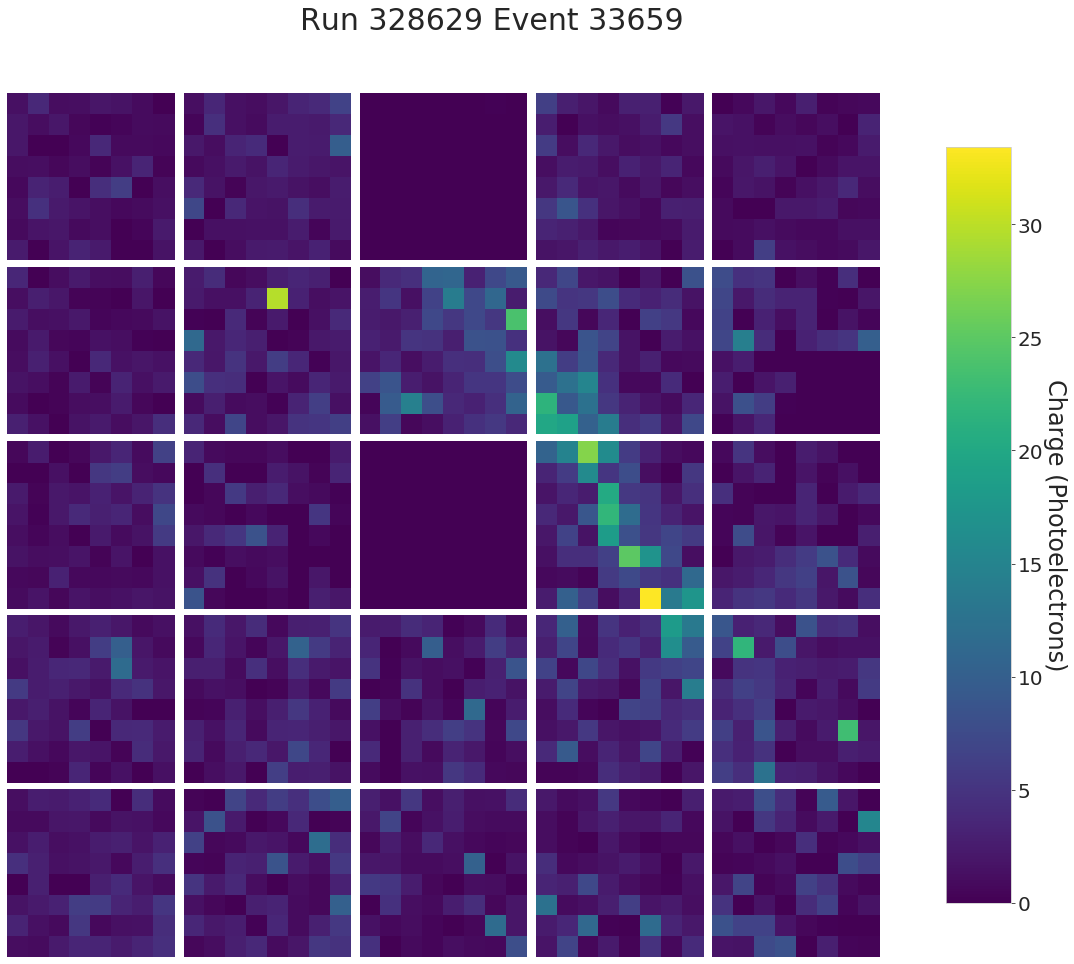

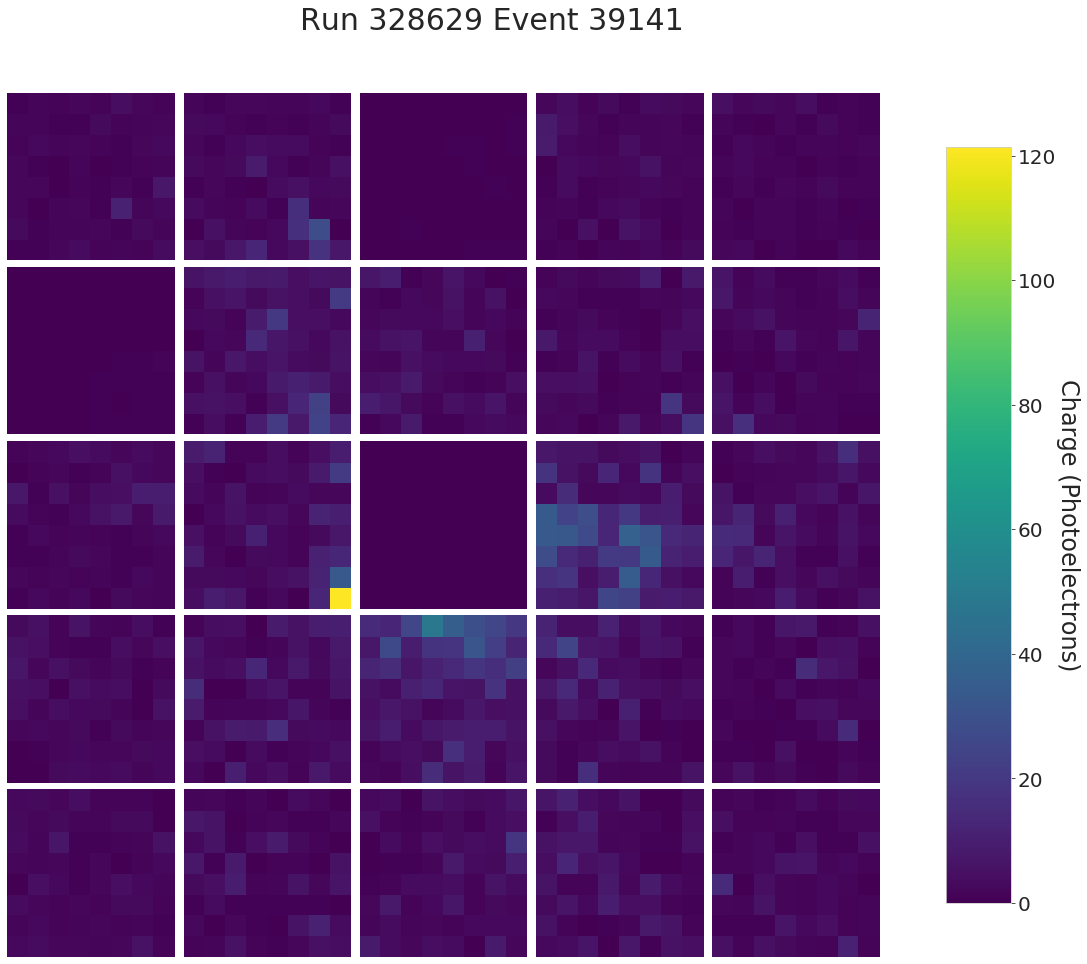

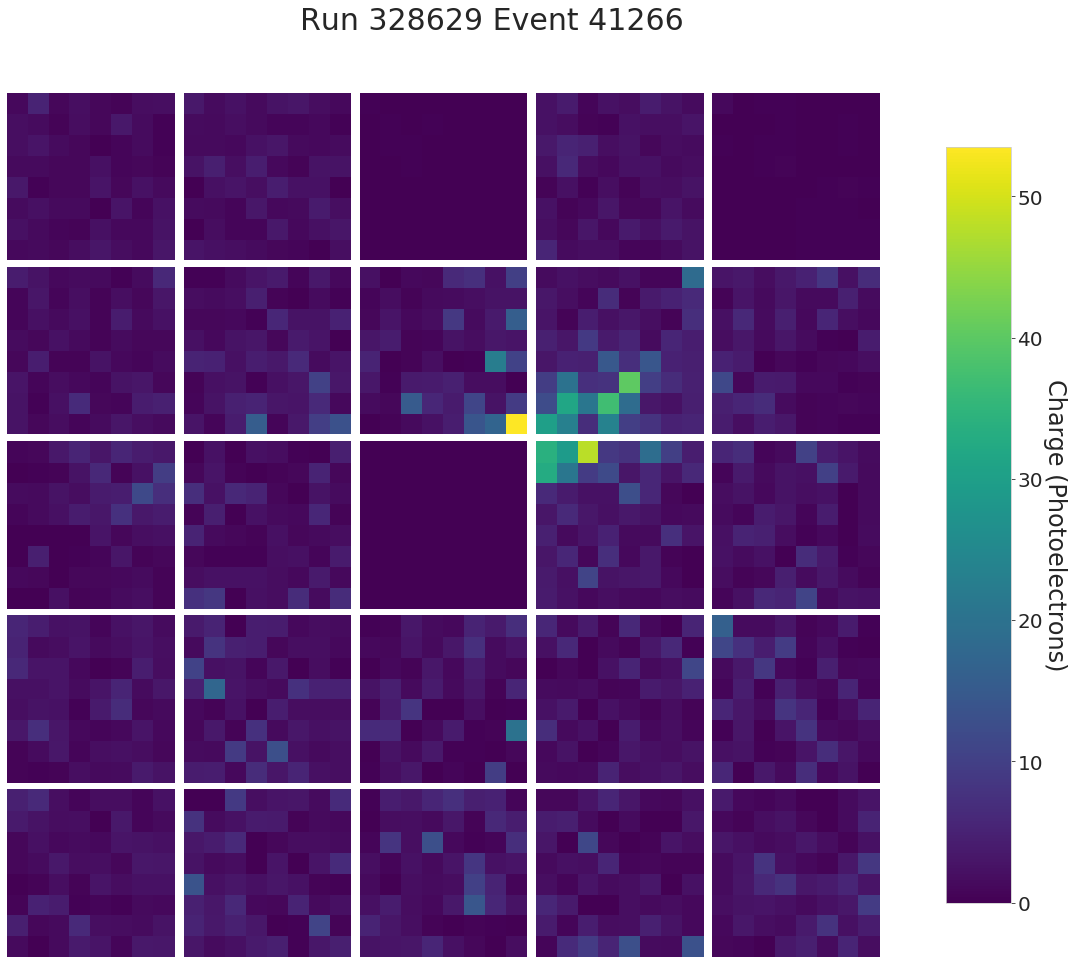

In [11]:
dis_special = [(data["run"][i], data["event"][i]) for i, val in enumerate(data["dis"]) if val > 5 and val < 6]
reader = target_io.WaveformArrayReader("/home/bmode/cam_data/cal328629.r1")
n_pixels = reader.fNPixels
n_samples = reader.fNSamples
waveforms = np.zeros((n_pixels, n_samples), dtype=np.float32)
for tup in dis_special[5:10]:
    ev = int(tup[1])
    reader.GetR1Event(ev, waveforms)
    peak_position = np.argmax(waveforms, axis=1)
    charges = mcs.calculate_charge(waveforms, peak_position, n_samples)
    charges = apply_gains(charges)
    image = np.zeros((40, 40))
    for i, val in enumerate(charges):
        image[grid_ind[i] // 40, grid_ind[i] % 40] = val
    camera_image(image, 328629, ev)
    plt.show()

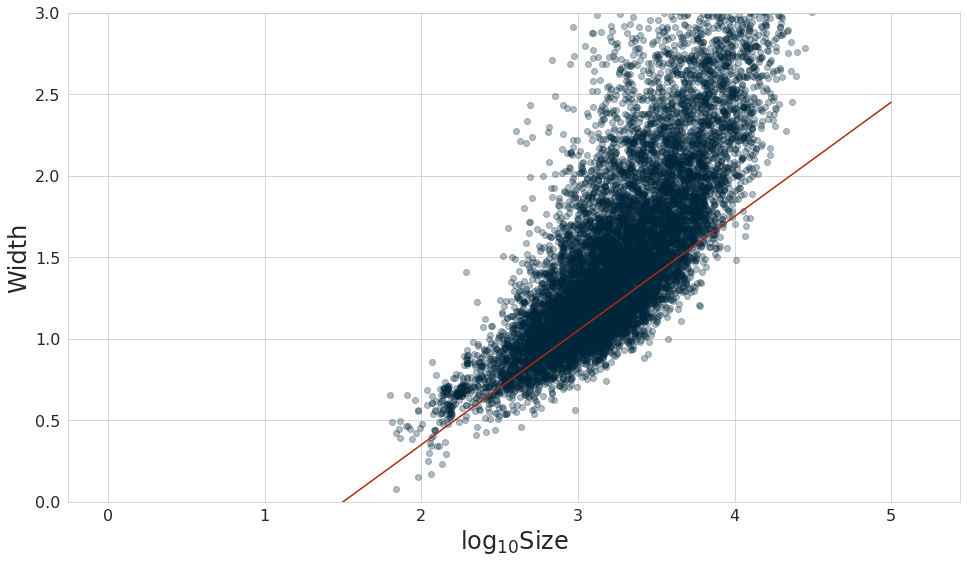

In [219]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
x = np.logspace(0, 5, 1000)
ax.scatter(np.log10(data["size"]), data["width"], alpha=0.3)
ax.plot(np.log10(x), -1.05+0.7*np.log10(x), color=palette[-2])
ax.set_ylim((0, 3))
ax.set_xlabel(r"$\log_{10}$Size", fontsize=24)
ax.set_ylabel("Width", fontsize=24)
ax.tick_params(labelsize=16)

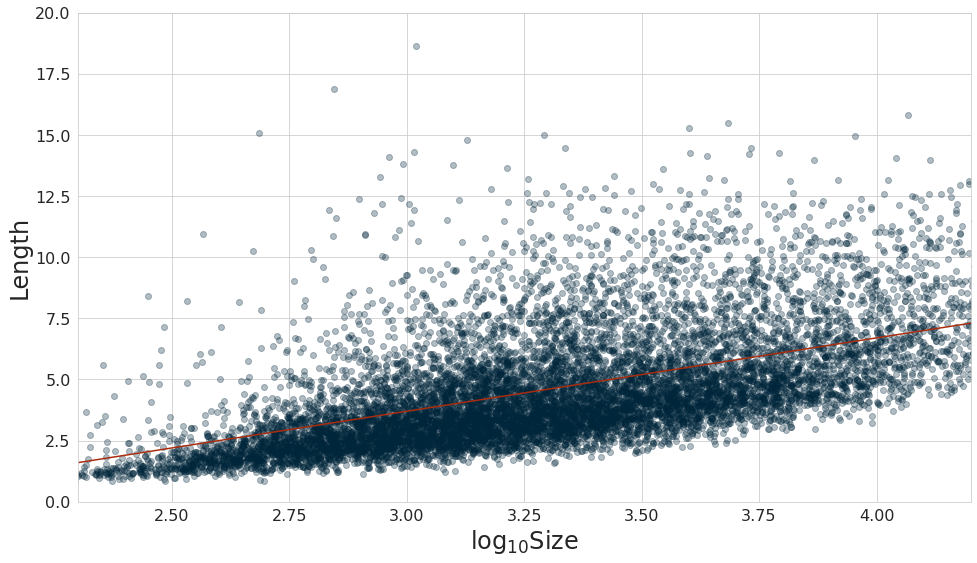

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

ax.scatter(np.log10(data["size"]), data["length"], alpha=0.3)
ax.plot(np.log10(x), -5.3+3.0*np.log10(x), color=palette[-2])
ax.set_ylim((0, 20))
ax.set_xlim((2.3, 4.2))
ax.set_xlabel(r"$\log_{10}$Size", fontsize=24)
ax.set_ylabel("Length", fontsize=24)
ax.tick_params(labelsize=16)

Text(0.5, 0.98, 'pSCT VERITAS Coincident Data')

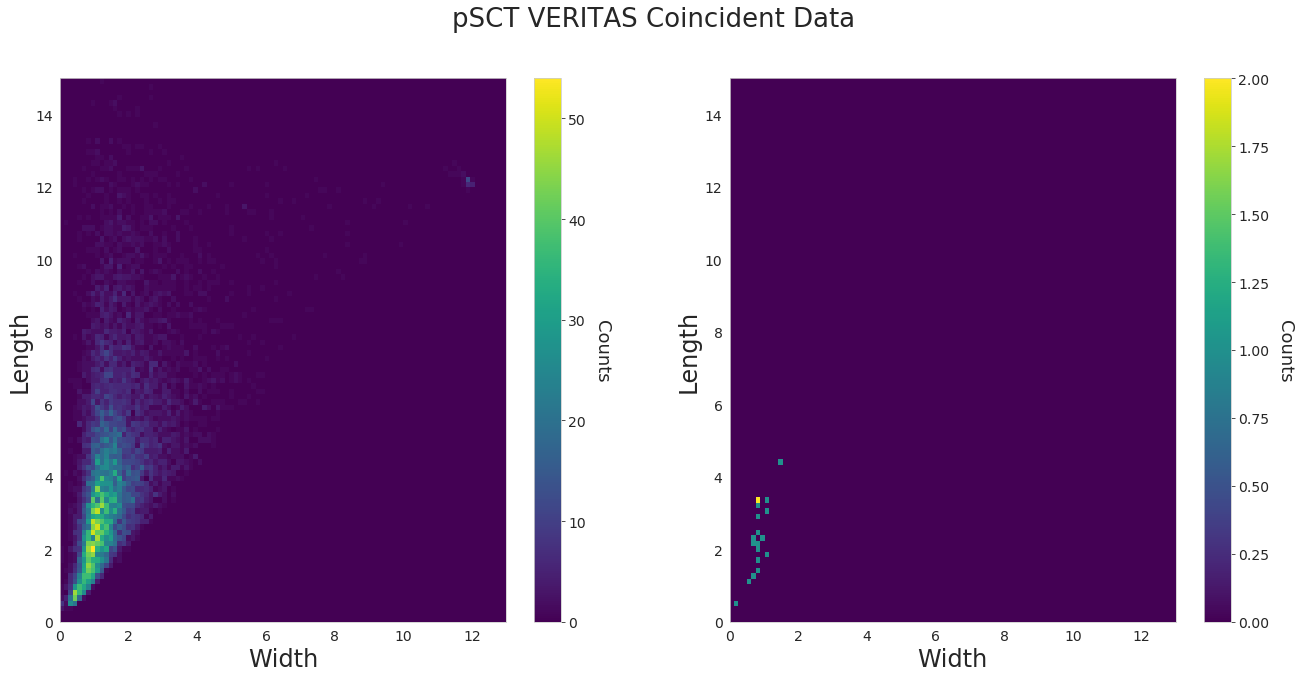

In [155]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
cax = ax[0].hist2d(cos_width, cos_length, bins=100, cmap="viridis", range=[[0, 13], [0, 15]])
cbar = fig.colorbar(cax[3], ax=ax[0])
cbar.set_label("Counts", size=18, rotation=270, labelpad=25)
cbar.ax.tick_params(labelsize=14)
ax[0].set_xlabel("Width", fontsize=24)
ax[0].set_ylabel("Length", fontsize=24)
ax[0].tick_params(labelsize=14)
cax = ax[1].hist2d(gam_width, gam_length, bins=100, cmap="viridis", range=[[0, 13], [0, 15]])
cbar = fig.colorbar(cax[3], ax=ax[1])
cbar.set_label("Counts", size=18, rotation=270, labelpad=25)
cbar.ax.tick_params(labelsize=14)
ax[1].set_xlabel("Width", fontsize=24)
ax[1].set_ylabel("Length", fontsize=24)
ax[1].tick_params(labelsize=14)
fig.suptitle("pSCT VERITAS Coincident Data", fontsize=26)

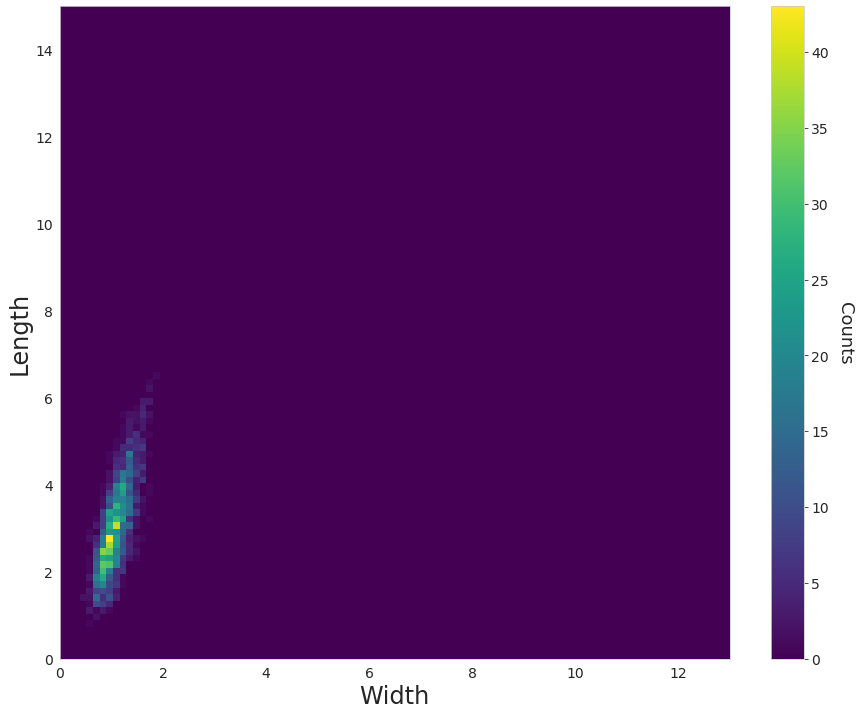

In [163]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 12))
cax = ax.hist2d(data["width"][first_cut], data["length"][first_cut], bins=100, cmap="viridis", range=[[0, 13], [0, 15]])
cbar = fig.colorbar(cax[3], ax=ax)
cbar.set_label("Counts", size=18, rotation=270, labelpad=25)
cbar.ax.tick_params(labelsize=14)
ax.set_xlabel("Width", fontsize=24)
ax.set_ylabel("Length", fontsize=24)
ax.tick_params(labelsize=14)

Text(0.5, 0.98, 'pSCT VERITAS Coincident Data')

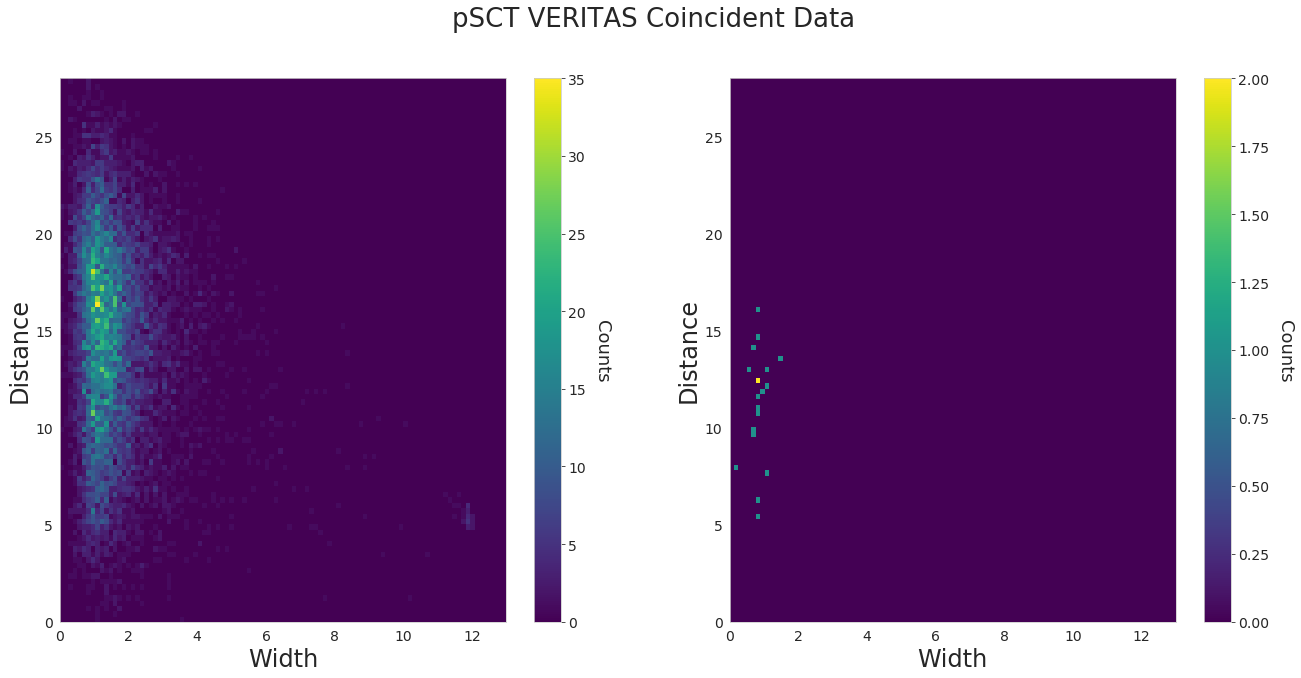

In [157]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
cax = ax[0].hist2d(cos_width, cos_dis, bins=100, cmap="viridis", range=[[0, 13], [0, 28]])
cbar = fig.colorbar(cax[3], ax=ax[0])
cbar.set_label("Counts", size=18, rotation=270, labelpad=25)
cbar.ax.tick_params(labelsize=14)
ax[0].set_xlabel("Width", fontsize=24)
ax[0].set_ylabel("Distance", fontsize=24)
ax[0].tick_params(labelsize=14)
cax = ax[1].hist2d(gam_width, gam_dis, bins=100, cmap="viridis", range=[[0, 13], [0, 28]])
cbar = fig.colorbar(cax[3], ax=ax[1])
cbar.set_label("Counts", size=18, rotation=270, labelpad=25)
cbar.ax.tick_params(labelsize=14)
ax[1].set_xlabel("Width", fontsize=24)
ax[1].set_ylabel("Distance", fontsize=24)
ax[1].tick_params(labelsize=14)
fig.suptitle("pSCT VERITAS Coincident Data", fontsize=26)

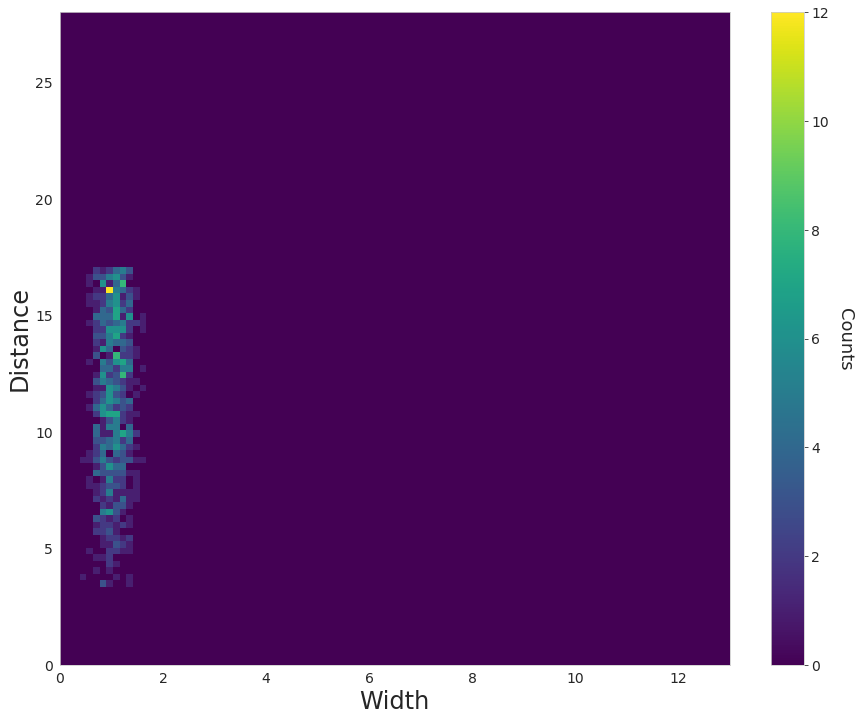

In [221]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 12))
cax = ax.hist2d(data["width"][first_cut], data["dis"][first_cut], bins=100, cmap="viridis", range=[[0, 13], [0, 28]])
cbar = fig.colorbar(cax[3], ax=ax)
cbar.set_label("Counts", size=18, rotation=270, labelpad=25)
cbar.ax.tick_params(labelsize=14)
ax.set_xlabel("Width", fontsize=24)
ax.set_ylabel("Distance", fontsize=24)
ax.tick_params(labelsize=14)

Text(0.5, 0.98, 'pSCT VERITAS Coincident Data')

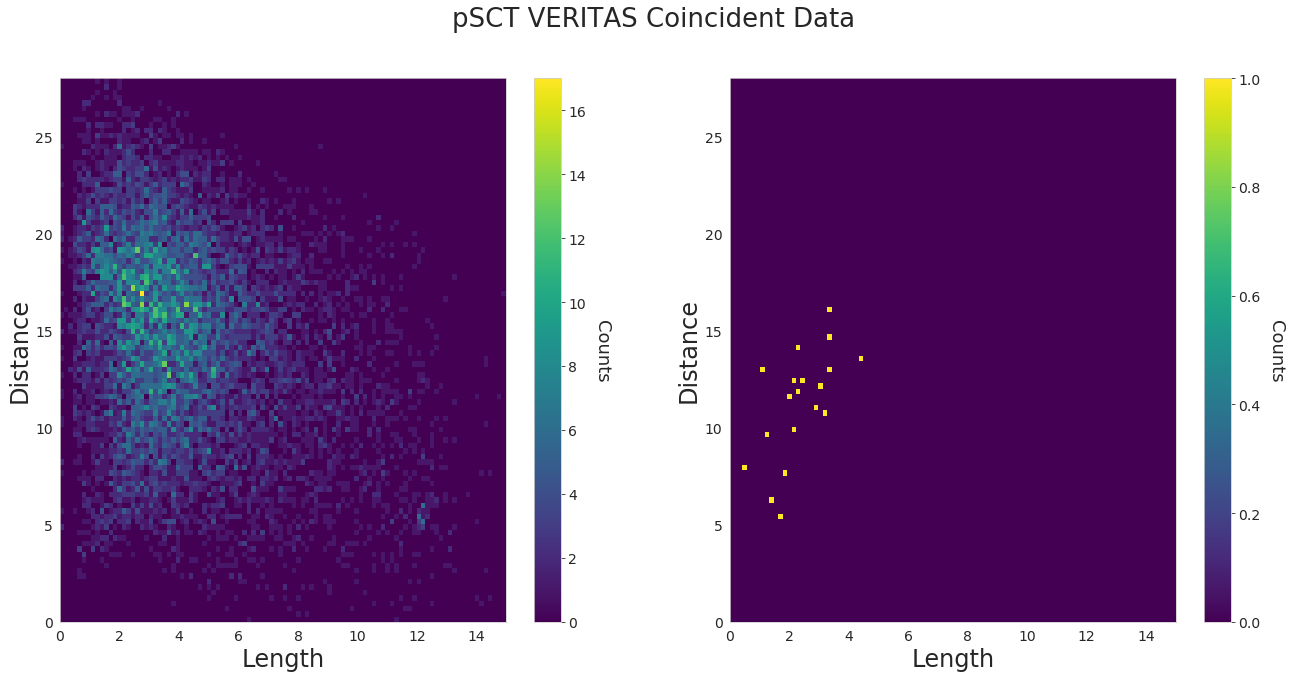

In [222]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
cax = ax[0].hist2d(cos_length, cos_dis, bins=100, cmap="viridis", range=[[0, 15], [0, 28]])
cbar = fig.colorbar(cax[3], ax=ax[0])
cbar.set_label("Counts", size=18, rotation=270, labelpad=25)
cbar.ax.tick_params(labelsize=14)
ax[0].set_xlabel("Length", fontsize=24)
ax[0].set_ylabel("Distance", fontsize=24)
ax[0].tick_params(labelsize=14)
cax = ax[1].hist2d(gam_length, gam_dis, bins=100, cmap="viridis", range=[[0, 15], [0, 28]])
cbar = fig.colorbar(cax[3], ax=ax[1])
cbar.set_label("Counts", size=18, rotation=270, labelpad=25)
cbar.ax.tick_params(labelsize=14)
ax[1].set_xlabel("Length", fontsize=24)
ax[1].set_ylabel("Distance", fontsize=24)
ax[1].tick_params(labelsize=14)
fig.suptitle("pSCT VERITAS Coincident Data", fontsize=26)

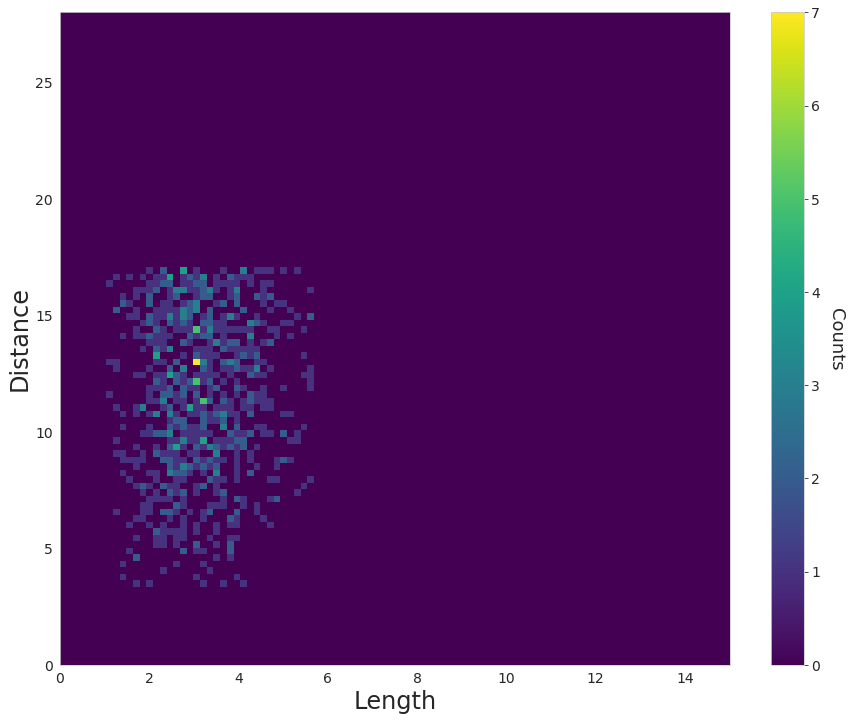

In [223]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 12))
cax = ax.hist2d(data["length"][first_cut], data["dis"][first_cut], bins=100, cmap="viridis", range=[[0, 15], [0, 28]])
cbar = fig.colorbar(cax[3], ax=ax)
cbar.set_label("Counts", size=18, rotation=270, labelpad=25)
cbar.ax.tick_params(labelsize=14)
ax.set_xlabel("Length", fontsize=24)
ax.set_ylabel("Distance", fontsize=24)
ax.tick_params(labelsize=14)

Text(0.5, 0.98, 'pSCT/VERITAS Coincident Data')

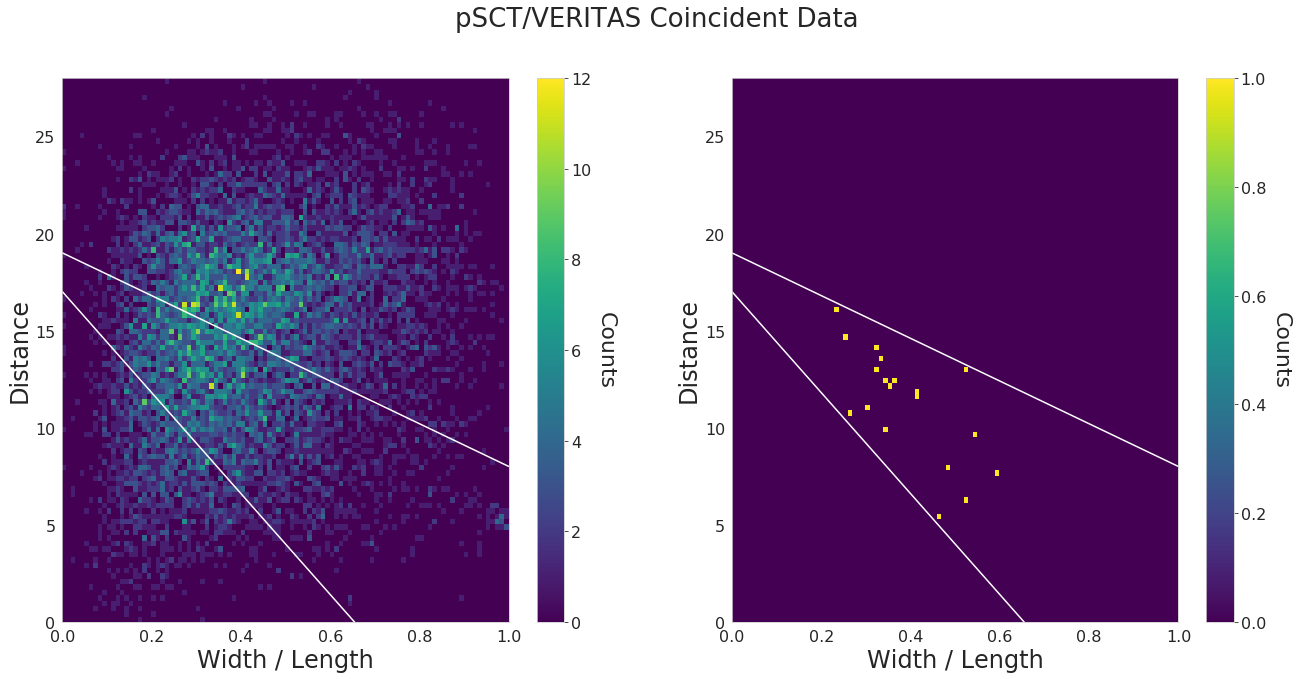

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
cax = ax[0].hist2d(np.asarray(cos_width)/np.asarray(cos_length), cos_dis, bins=100, cmap="viridis", range=[[0, 1], [0, 28]])
cbar = fig.colorbar(cax[3], ax=ax[0])
cbar.set_label("Counts", size=22, rotation=270, labelpad=25)
cbar.ax.tick_params(labelsize=16)
x = np.linspace(0., 1., 1000)
ax[0].plot(x, 19.-11.*x, color="white")
ax[0].plot(x, 17.-26.*x, color="white")
ax[0].set_xlabel("Width / Length", fontsize=24)
ax[0].set_ylabel("Distance", fontsize=24)
ax[0].tick_params(labelsize=16)
cax = ax[1].hist2d(np.asarray(gam_width)/np.asarray(gam_length), gam_dis, bins=100, cmap="viridis", range=[[0, 1], [0, 28]])
cbar = fig.colorbar(cax[3], ax=ax[1])
cbar.set_label("Counts", size=22, rotation=270, labelpad=25)
cbar.ax.tick_params(labelsize=16)
ax[1].plot(x, 19.-11.*x, color="white")
ax[1].plot(x, 17.-26.*x, color="white")
ax[1].set_xlabel("Width / Length", fontsize=24)
ax[1].set_ylabel("Distance", fontsize=24)
ax[1].tick_params(labelsize=16)
fig.suptitle("pSCT/VERITAS Coincident Data", fontsize=26)

Text(0.5, 1.0, 'pSCT/VERITAS Coincident Data')

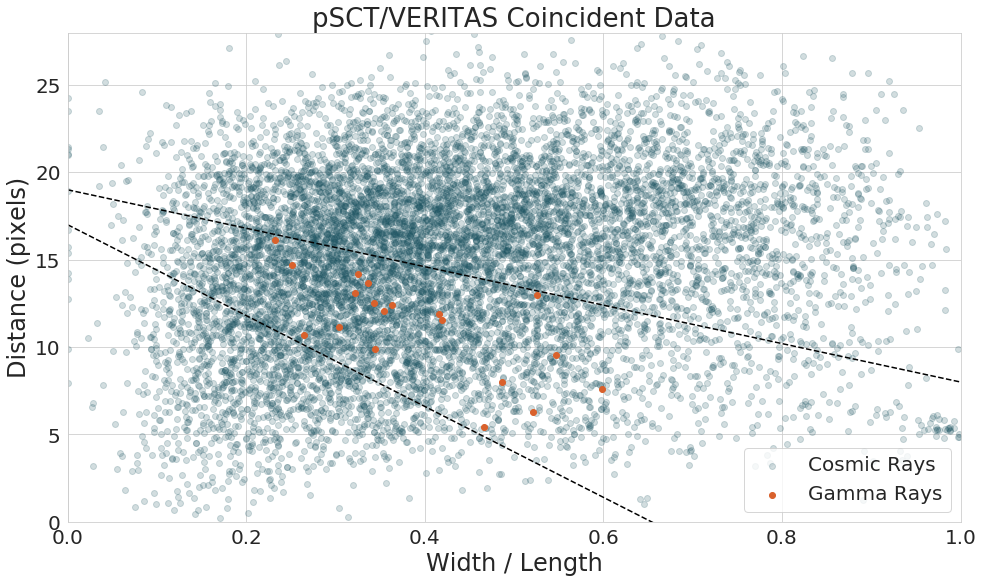

In [6]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.scatter(np.asarray(cos_width)/np.asarray(cos_length), cos_dis, color=palette[1], alpha=0.2, label="Cosmic Rays")
ax.scatter(np.asarray(gam_width)/np.asarray(gam_length), gam_dis, color=palette[6], label="Gamma Rays")
x = np.linspace(0., 1., 1000)
ax.plot(x, 19.-11.*x, color="black", linestyle="--")
ax.plot(x, 17.-26.*x, color="black", linestyle="--")
ax.set_xlim((0, 1))
ax.set_ylim((0, 28))
ax.set_xlabel("Width / Length", fontsize=24)
ax.set_ylabel("Distance (pixels)", fontsize=24)
ax.legend(fontsize=20)
ax.tick_params(labelsize=20)
ax.set_title("pSCT/VERITAS Coincident Data", fontsize=26)

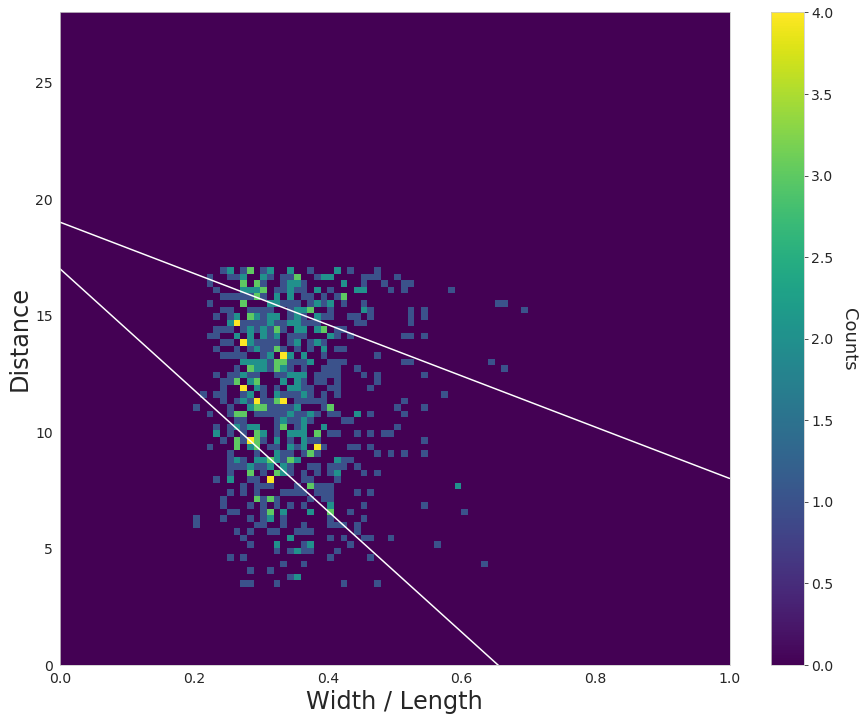

In [241]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 12))
cax = ax.hist2d(data["width"][first_cut]/data["length"][first_cut], data["dis"][first_cut], bins=100, cmap="viridis", range=[[0, 1], [0, 28]])
cbar = fig.colorbar(cax[3], ax=ax)
cbar.set_label("Counts", size=18, rotation=270, labelpad=25)
cbar.ax.tick_params(labelsize=14)
ax.plot(x, 19.-11.*x, color="white")
ax.plot(x, 17.-26.*x, color="white")
ax.set_xlabel("Width / Length", fontsize=24)
ax.set_ylabel("Distance", fontsize=24)
ax.tick_params(labelsize=14)

In [4]:
cos_width = []
cos_length = []
cos_dis = []
cos_size = []
cos_alpha = []
cos_frac3 = []
gam_width = []
gam_length = []
gam_dis = []
gam_size = []
gam_alpha = []
gam_events = []
gam_frac3 = []
runs = [328629, 328630, 328631]
for run in runs:
    file_ = f"{run}_cosrays_hillas.csv"
    _, _, _, _, _, _, temp_size, temp_frac3, _, _, temp_width, temp_length, _, temp_dis, _, temp_alpha = np.loadtxt(file_, delimiter=", ", skiprows=1, unpack=True)
    cos_width.extend(temp_width)
    cos_length.extend(temp_length)
    cos_dis.extend(temp_dis)
    cos_size.extend(temp_size)
    cos_alpha.extend(temp_alpha)
    cos_frac3.extend(temp_frac3)
for run in runs:
    file_ = f"{run}_gammas_hillas.csv"
    temp_events, _, _, _, _, _, temp_size, temp_frac3, _, _, temp_width, temp_length, _, temp_dis, _, temp_alpha = np.loadtxt(file_, delimiter=", ", skiprows=1, unpack=True)
    gam_width.extend(temp_width)
    gam_length.extend(temp_length)
    gam_dis.extend(temp_dis)
    gam_size.extend(temp_size)
    gam_alpha.extend(temp_alpha)
    gam_events.extend(temp_events)
    gam_frac3.extend(temp_frac3)

In [356]:
run = data["run"]
event = data["event"]
size = data["size"]
width = data["width"]
length = data["length"]
dis = data["dis"]
alpha = data["alpha"]
first_cut = [i for i, val in enumerate(width) if val < -1.05+0.7*np.log10(size[i]) 
             and length[i] < -5.3+3.0*np.log10(size[i]) 
             and size[i] > 250
             and size[i] < 20000
             and dis[i] < 17
             and dis[i] < 19.-11.*(width[i] / length[i])
             and dis[i] > 17.-26.*(width[i] / length[i])]

In [109]:
print(len(run))
print(len(first_cut))
print(len([val for val in alpha[first_cut] if val <= 10.0]))

11742
1805
1805


Text(0.5, 1.0, 'Coast to Coast Data')

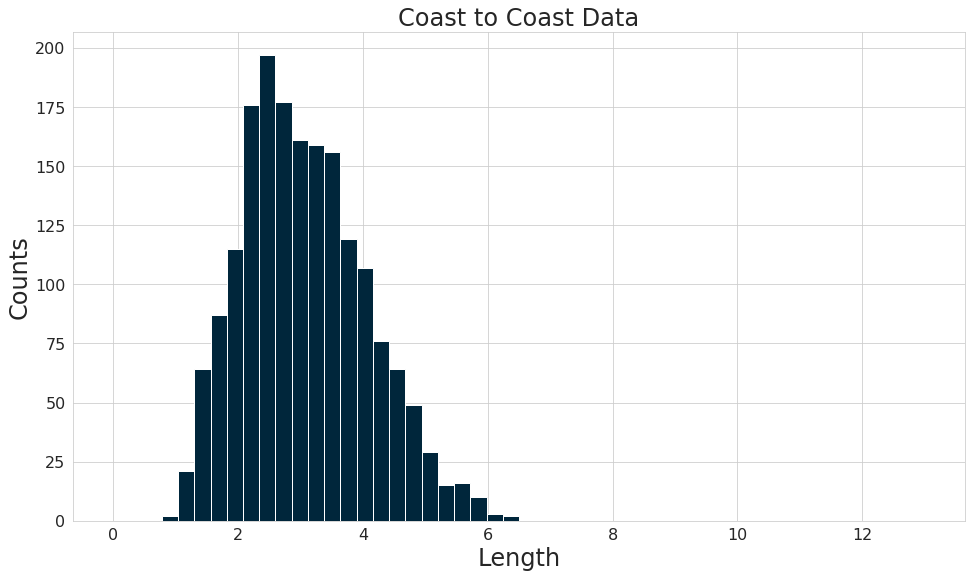

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.hist(length[first_cut], bins=50, range=(0, 13))
ax.set_xlabel("Length", fontsize=24)
ax.set_ylabel("Counts", fontsize=24)
ax.tick_params(labelsize=16)
ax.set_title("Coast to Coast Data", fontsize=24)

Text(0.5, 1.0, 'Coast to Coast Data')

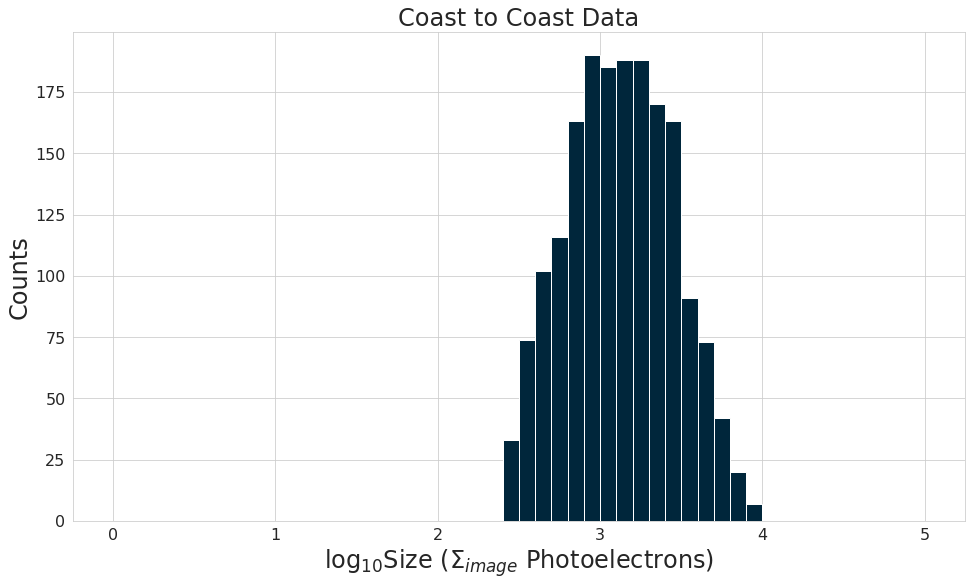

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.hist(np.log10(size[first_cut]), bins=50, range=(0, 5))
ax.set_xlabel(r"$\log_{10}$Size ($\Sigma_{image}$ Photoelectrons)", fontsize=24)
ax.set_ylabel("Counts", fontsize=24)
ax.tick_params(labelsize=16)
ax.set_title("Coast to Coast Data", fontsize=24)

Text(0.5, 1.0, 'Coast to Coast Data')

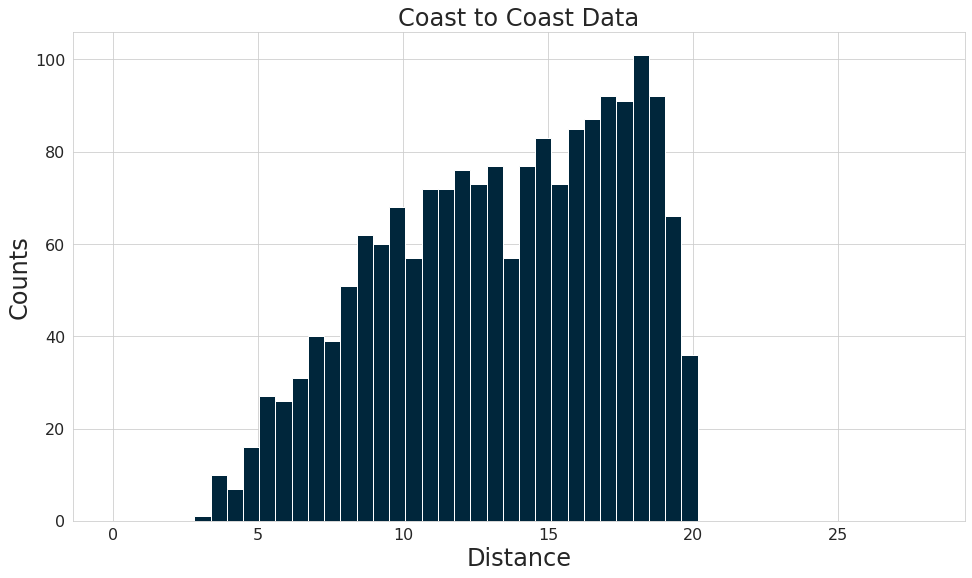

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.hist(dis[first_cut], bins=50, range=(0, 28))
ax.set_xlabel("Distance", fontsize=24)
ax.set_ylabel("Counts", fontsize=24)
ax.tick_params(labelsize=16)
ax.set_title("Coast to Coast Data", fontsize=24)

Text(0.5, 1.0, 'Coast to Coast Data')

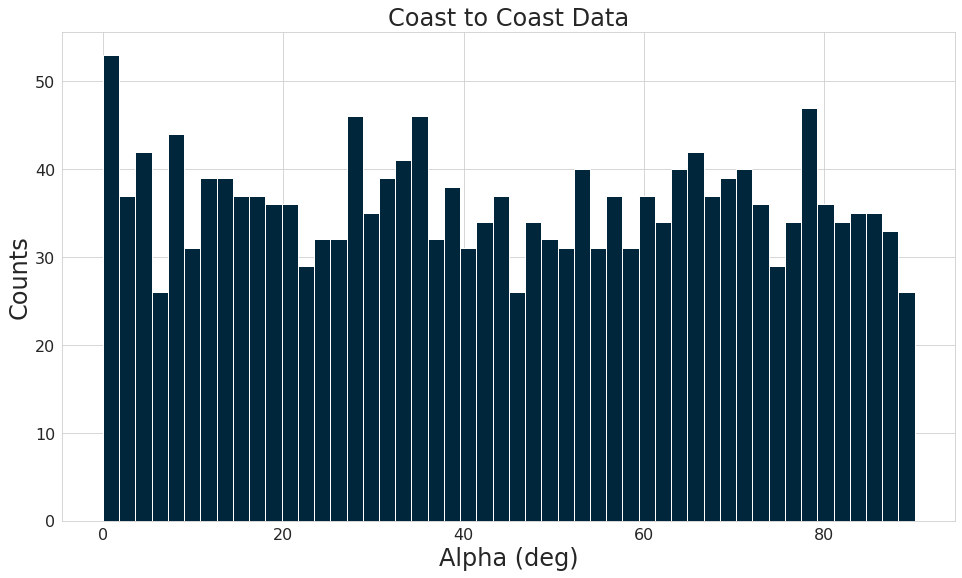

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.hist(np.degrees(alpha[first_cut]), bins=50, range=(0, 90))
ax.set_xlabel("Alpha (deg)", fontsize=24)
ax.set_ylabel("Counts", fontsize=24)
ax.tick_params(labelsize=16)
ax.set_title("Coast to Coast Data", fontsize=24)

[16. 12. 12.  5. 11.  7.  2.  4. 10.  6. 10.  8.  5.  7.  5.  4.  4.  4.
  3.  4.  5.  3.  6.  4.  6.  6.  4.  8.  5.  4.  8.  3.  4.  6.  8.  3.
  2.  7.  8.  4.  5.  5.  3.  6.  8.  4.  6.  5.  6.  2.  6.  2.  5.  5.
  8.  1.  9.  8.  3.  8.  6.  6.  6.  7.  4.  7.  3.  6.  6.  3.  7.  5.
  4.  5.  6.  4.  6.  7.  4.  4.  4.  2.  6.  5.  7. 10.  5.  2.  6.  3.]
11742


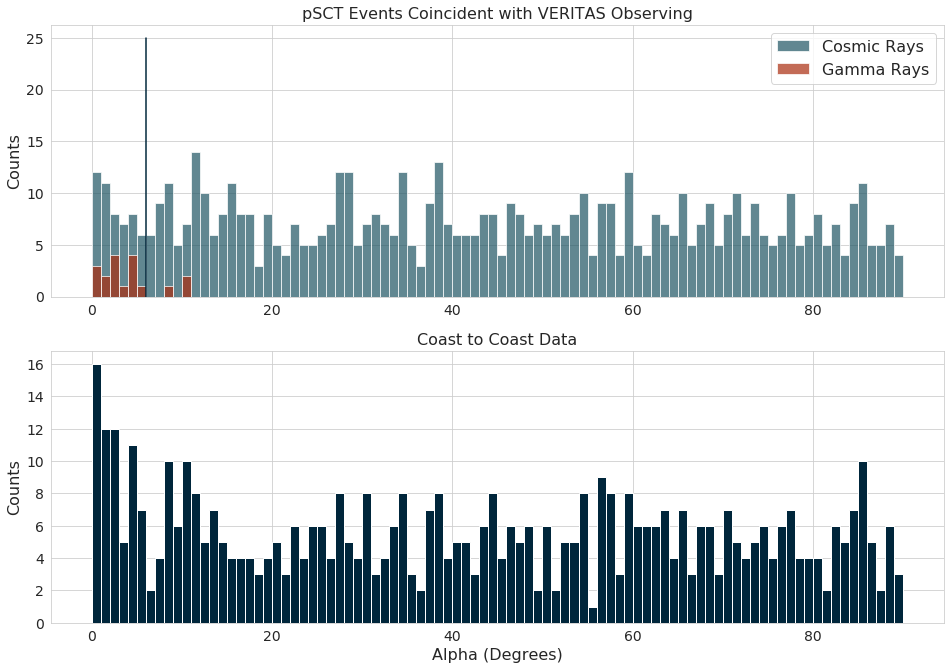

In [368]:
first_cut_cosrays = [i for i, val in enumerate(cos_width) if val < -0.95+0.7*np.log10(cos_size[i]) and cos_length[i] < -5.3+3.0*np.log10(cos_size[i]) and cos_size[i] > 250 and cos_dis[i] < 20 and cos_dis[i] < 19.-11.*(cos_width[i] / cos_length[i]) and cos_dis[i] > 17.-26.*(cos_width[i] / cos_length[i])]
first_cut_gammas = [i for i, val in enumerate(gam_width) if val < -0.95+0.7*np.log10(gam_size[i]) and gam_length[i] < -5.3+3.0*np.log10(gam_size[i]) and gam_size[i] > 250 and gam_dis[i] < 20]
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 11))
ax[0].hist(np.degrees(np.asarray(cos_alpha)[first_cut_cosrays]), bins=90, density=False, alpha=0.7, label="Cosmic Rays", range=(0, 90), color=palette[1])
ax[0].hist(np.degrees(np.asarray(gam_alpha)[first_cut_gammas]), bins=90, density=False, alpha=0.7, label="Gamma Rays", range=(0, 90), color=palette[-2])
#ax[0].plot([12.0, 12.0], [0.0, 25.])
ax[0].plot([6.0, 6.0], [0.0, 25.])
ax[0].set_title("pSCT Events Coincident with VERITAS Observing", fontsize=16)
stuff, _, _ = ax[1].hist(np.degrees(alpha[first_cut]), bins=90, range=(0, 90))
ax[1].set_title("Coast to Coast Data", fontsize=16)
ax[0].legend(fontsize=16)
ax[1].set_xlabel("Alpha (Degrees)", fontsize=16)
for i in range(2):
    ax[i].set_ylabel("Counts", fontsize=16)
    ax[i].tick_params(labelsize=14)
print(stuff)
print(len(data["run"]))

In [366]:
print(len([val for val in np.degrees(alpha[first_cut]) if val if val < 6.]))

63


In [10]:
DATADIR = "/home/bmode/data/crab_data/v0.3"
runs = {328555: "on", 328557: "allon", 328564: "off", 
        328565: "on", 328567: "on", 328569: "off", 328572: "off", 
        328573: "on", 328574: "on", 328581: "off", 328583: "off",
        328585: "on", 328592: "off", 328597: "off", 328599: "on",
        328606: "off", 328608: "on", 328610: "on", 328615: "off",
        328617: "on", 328619: "on", 328627: "off", 328629: "allon",
        328630: "allon", 328631: "allon", 328640: "off", 328642: "on",
        328646: "on", 328700: "on", 328717: "off", 328719: "on",
        328732: "on", 328733: "on", 328748: "on", 328750: "on",
        328761: "on", 328763: "on", 328770: "on", 328772: "on",
        328781: "on", 328792: "on", 328794: "on", 328821: "on",
        328846: "on", 328854: "on", 328856: "on", 328865: "on",
        328867: "on"}
all_off_data = []
for r in runs.keys():
    if runs[r] != "allon":
        temp = np.loadtxt(f"{DATADIR}/off_data_run{r}.txt", skiprows=1, delimiter=", ")
        all_off_data.extend(temp)
all_off_data = np.asarray(all_off_data).T
        
off_data = {"run": all_off_data[0],
        "event": all_off_data[1],
        "tack": all_off_data[4],
        "size": all_off_data[7],
        "frac2": all_off_data[8],
        "x": all_off_data[11],
        "y": all_off_data[12],
        "width": all_off_data[13],
        "length": all_off_data[14],
        "dis": all_off_data[16],
        "alpha": all_off_data[18]}

/home/bmode/anaconda2/envs/python_3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/home/bmode/anaconda2/envs/python_3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/bmode/anaconda2/envs/python_3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, 'OFF Data')

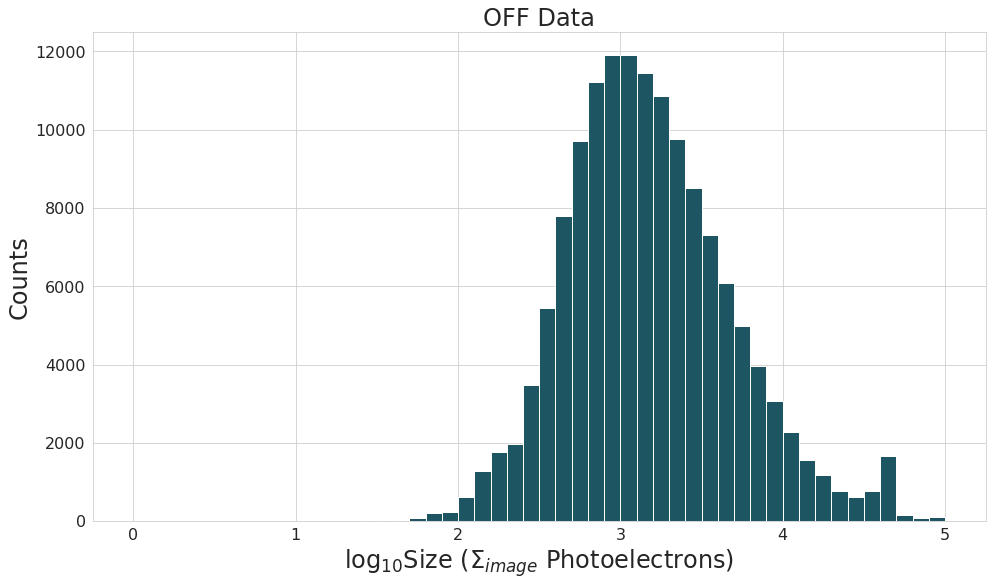

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.hist(np.log10(off_data["size"]), bins=50, range=(0, 5), color=palette[1])
ax.set_xlabel(r"$\log_{10}$Size ($\Sigma_{image}$ Photoelectrons)", fontsize=24)
ax.set_ylabel("Counts", fontsize=24)
ax.tick_params(labelsize=16)
ax.set_title("OFF Data", fontsize=24)

Text(0.5, 1.0, 'OFF Data')

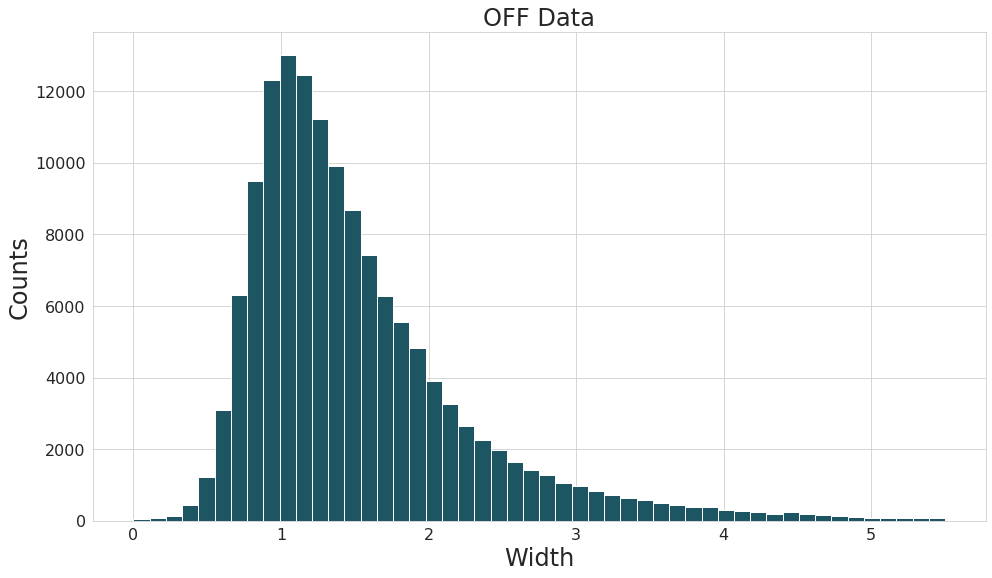

In [81]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.hist(off_data["width"], bins=50, range=(0, 5.5), color=palette[1])
ax.set_xlabel("Width", fontsize=24)
ax.set_ylabel("Counts", fontsize=24)
ax.tick_params(labelsize=16)
ax.set_title("OFF Data", fontsize=24)

Text(0.5, 1.0, 'OFF Data')

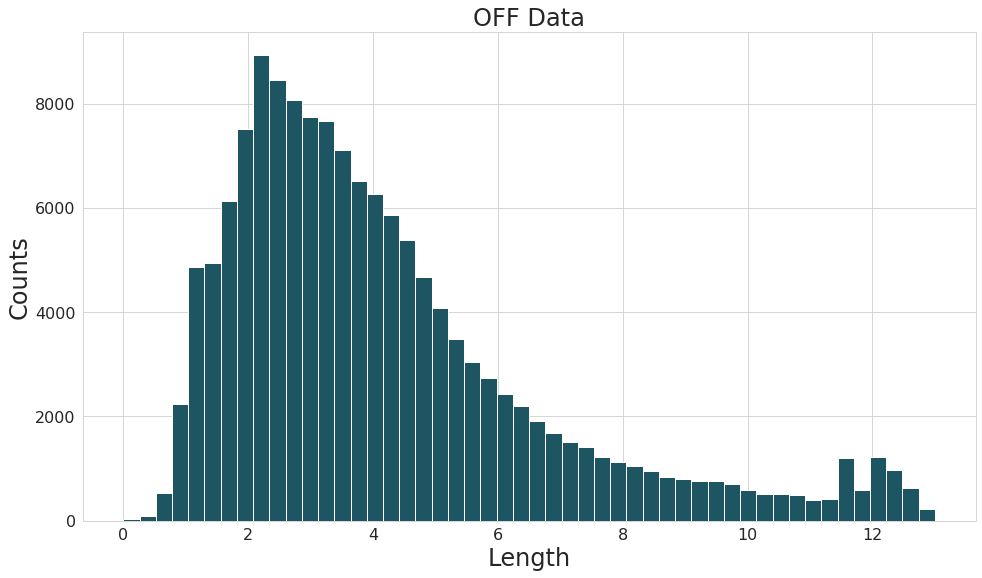

In [82]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.hist(off_data["length"], bins=50, range=(0, 13), color=palette[1])
ax.set_xlabel("Length", fontsize=24)
ax.set_ylabel("Counts", fontsize=24)
ax.tick_params(labelsize=16)
ax.set_title("OFF Data", fontsize=24)

Text(0.5, 1.0, 'OFF Data')

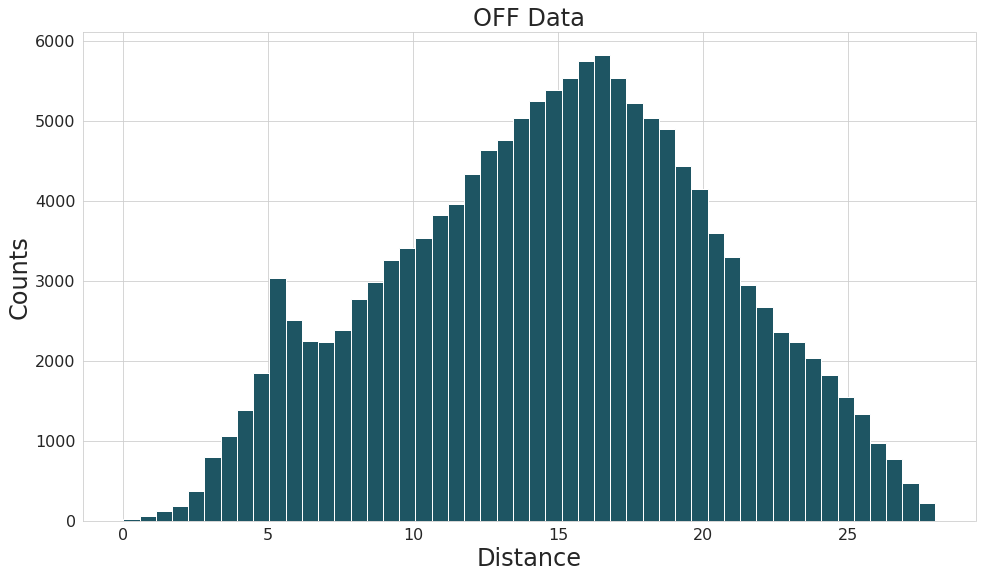

In [83]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.hist(off_data["dis"], bins=50, range=(0, 28), color=palette[1])
ax.set_xlabel("Distance", fontsize=24)
ax.set_ylabel("Counts", fontsize=24)
ax.tick_params(labelsize=16)
ax.set_title("OFF Data", fontsize=24)

Text(0.5, 1.0, 'OFF Data')

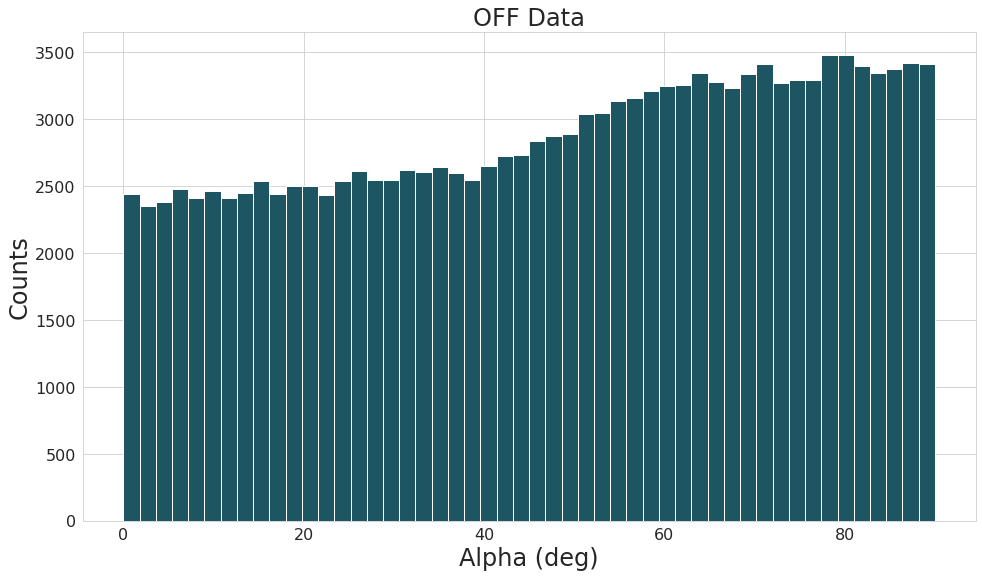

In [84]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.hist(np.degrees(off_data["alpha"]), bins=50, range=(0, 90), color=palette[1])
ax.set_xlabel("Alpha (deg)", fontsize=24)
ax.set_ylabel("Counts", fontsize=24)
ax.tick_params(labelsize=16)
ax.set_title("OFF Data", fontsize=24)

/home/bmode/anaconda2/envs/python_3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


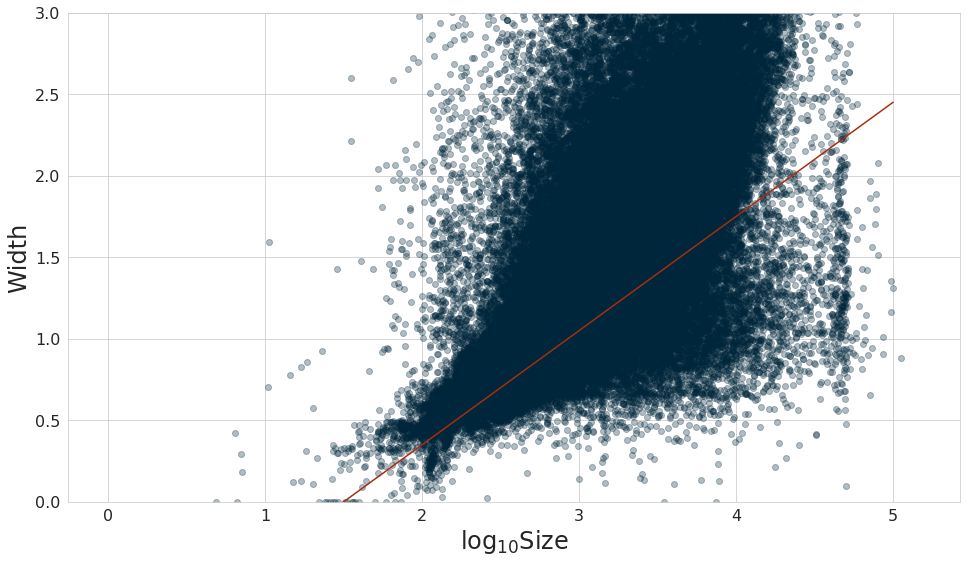

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
x = np.logspace(0, 5, 1000)
ax.scatter(np.log10(off_data["size"]), off_data["width"], alpha=0.3)
ax.plot(np.log10(x), -1.05+0.7*np.log10(x), color=palette[-2])
ax.set_ylim((0, 3))
ax.set_xlabel(r"$\log_{10}$Size", fontsize=24)
ax.set_ylabel("Width", fontsize=24)
ax.tick_params(labelsize=16)

/home/bmode/anaconda2/envs/python_3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


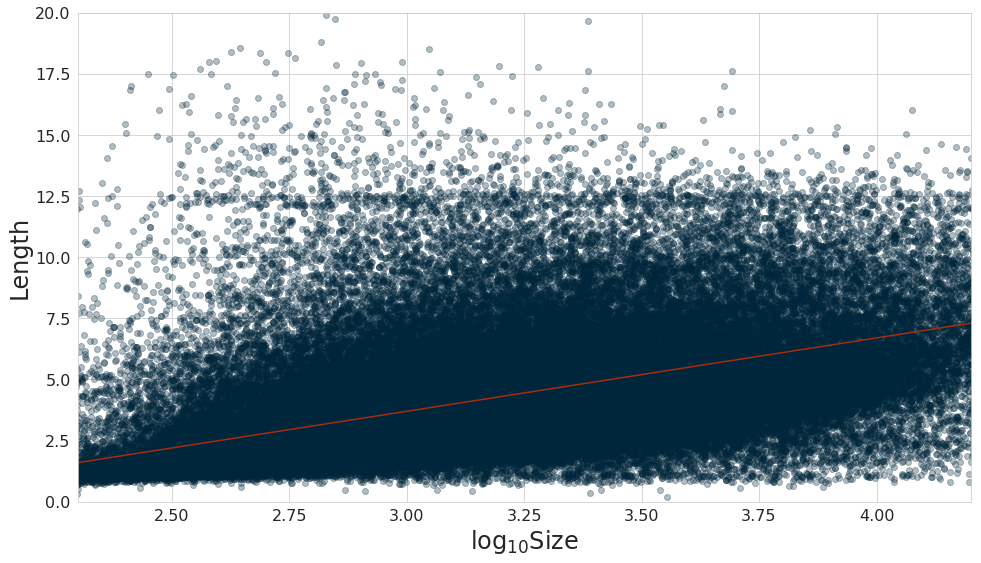

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

ax.scatter(np.log10(off_data["size"]), off_data["length"], alpha=0.3)
ax.plot(np.log10(x), -5.3+3.0*np.log10(x), color=palette[-2])
ax.set_ylim((0, 20))
ax.set_xlim((2.3, 4.2))
ax.set_xlabel(r"$\log_{10}$Size", fontsize=24)
ax.set_ylabel("Length", fontsize=24)
ax.tick_params(labelsize=16)

/home/bmode/anaconda2/envs/python_3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'OFF Data - Cut')

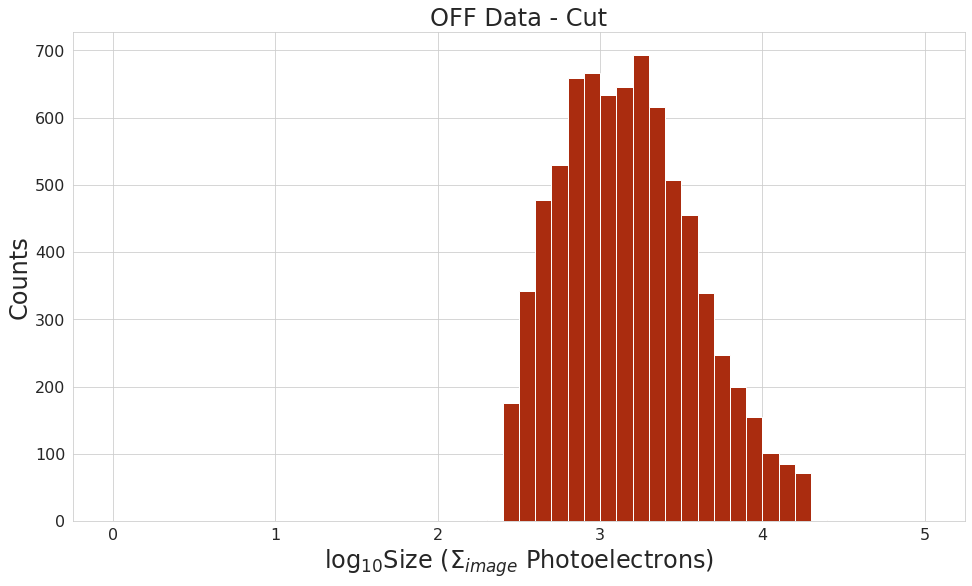

In [299]:
cut = [i for i, val in enumerate(off_data["width"]) if val < -1.05+0.7*np.log10(off_data["size"][i]) 
       and off_data["length"][i] < -5.3+3.0*np.log10(off_data["size"][i]) 
       and off_data["size"][i] > 250.
       and off_data["size"][i] < 20000.
       and off_data["dis"][i] < 17.
       and off_data["dis"][i] > 5.
       and off_data["dis"][i] < 19.0-11.0*(off_data["width"][i]/off_data["length"][i])
       and off_data["dis"][i] > 17.0-26.0*(off_data["width"][i]/off_data["length"][i])]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.hist(np.log10(off_data["size"][cut]), bins=50, range=(0, 5), color=palette[7])
ax.set_xlabel(r"$\log_{10}$Size ($\Sigma_{image}$ Photoelectrons)", fontsize=24)
ax.set_ylabel("Counts", fontsize=24)
ax.tick_params(labelsize=16)
ax.set_title("OFF Data - Cut", fontsize=24)

Text(0.5, 1.0, 'OFF Data - Cut')

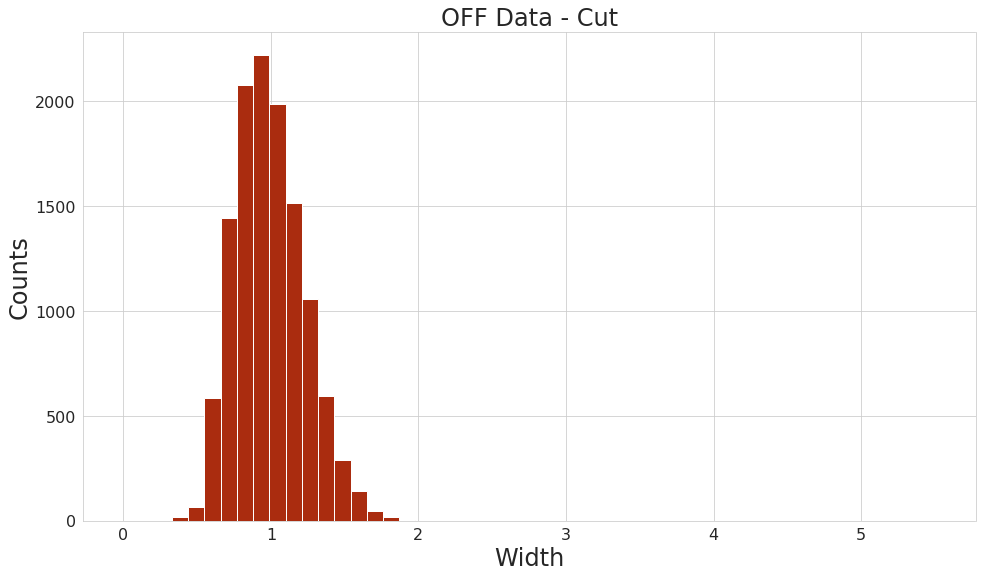

In [262]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.hist(off_data["width"][cut], bins=50, range=(0, 5.5), color=palette[7])
ax.set_xlabel("Width", fontsize=24)
ax.set_ylabel("Counts", fontsize=24)
ax.tick_params(labelsize=16)
ax.set_title("OFF Data - Cut", fontsize=24)

Text(0.5, 1.0, 'OFF Data - Cut')

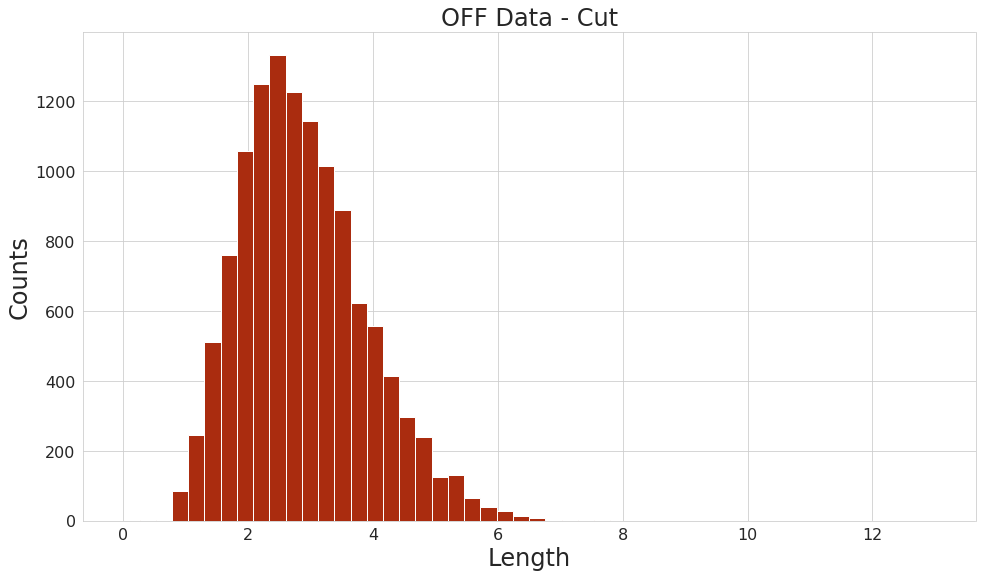

In [263]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.hist(off_data["length"][cut], bins=50, range=(0, 13), color=palette[7])
ax.set_xlabel("Length", fontsize=24)
ax.set_ylabel("Counts", fontsize=24)
ax.tick_params(labelsize=16)
ax.set_title("OFF Data - Cut", fontsize=24)

Text(0.5, 1.0, 'OFF Data - Cut')

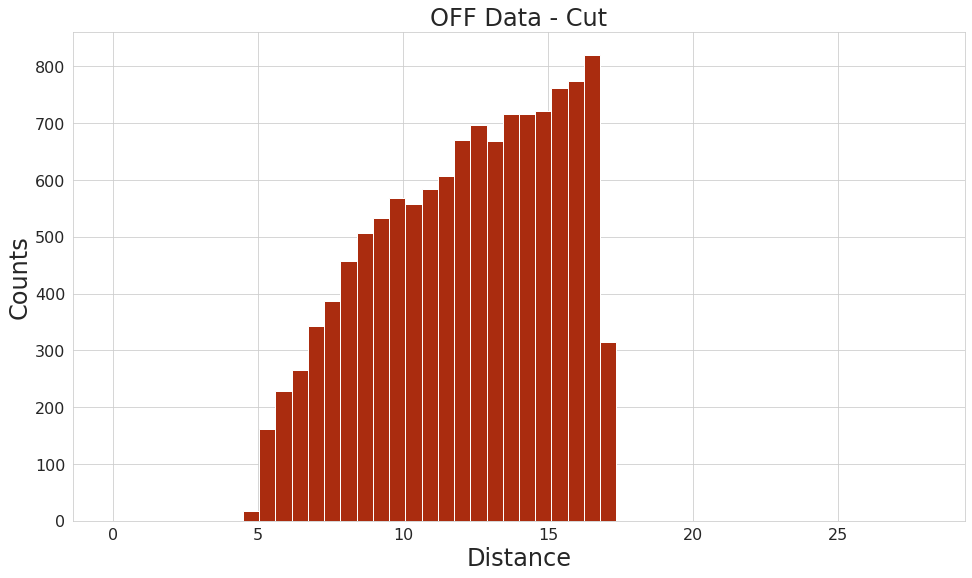

In [264]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.hist(off_data["dis"][cut], bins=50, range=(0, 28), color=palette[7])
ax.set_xlabel("Distance", fontsize=24)
ax.set_ylabel("Counts", fontsize=24)
ax.tick_params(labelsize=16)
ax.set_title("OFF Data - Cut", fontsize=24)

Text(0.5, 1.0, 'OFF Data - Cut')

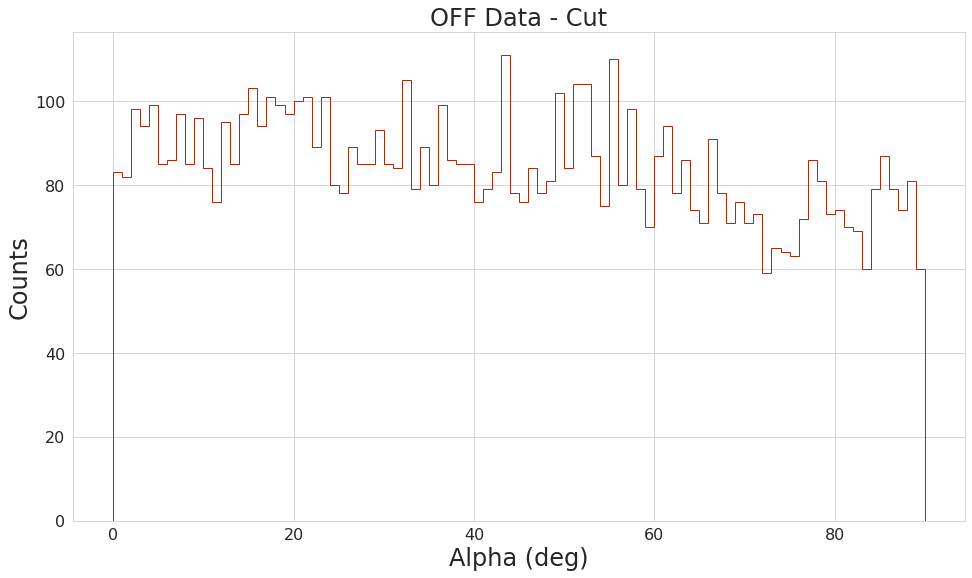

In [351]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.hist(np.degrees(off_data["alpha"][cut]), bins=90, range=(0, 90), color=palette[7], histtype="step")
ax.set_xlabel("Alpha (deg)", fontsize=24)
ax.set_ylabel("Counts", fontsize=24)
ax.tick_params(labelsize=16)
ax.set_title("OFF Data - Cut", fontsize=24)

In [7]:
def li_ma_sig(alpha, N_on, N_off):
    return(np.sqrt(2)*np.sqrt((N_on*np.log((1+alpha)*N_on/(alpha*(N_on+N_off)))
                       +N_off*np.log((1+alpha)*N_off/(N_off+N_on)))))

In [276]:
print(len(off_data["width"]))
print(len(off_data["width"][cut]))
print(len([val for val in off_data["alpha"][cut] if np.degrees(val) <= 12.0]))

144230
12075
1554


In [277]:
li_ma_sig(1, 1554+170, 1554)

2.9699002841031694

In [145]:
2481-2207

274

In [198]:
spike = [(off_data["run"][i], off_data["event"][i]) for i, val in enumerate(off_data["dis"]) if val > 3.0 and val < 4.0]
spike

[(328555.0, 243529.0),
 (328555.0, 245619.0),
 (328555.0, 245982.0),
 (328555.0, 252881.0),
 (328555.0, 256052.0),
 (328555.0, 259510.0),
 (328555.0, 260485.0),
 (328555.0, 263869.0),
 (328555.0, 267216.0),
 (328555.0, 267414.0),
 (328555.0, 268770.0),
 (328555.0, 275086.0),
 (328555.0, 275627.0),
 (328555.0, 277022.0),
 (328555.0, 277277.0),
 (328555.0, 278431.0),
 (328555.0, 282873.0),
 (328555.0, 291259.0),
 (328555.0, 304534.0),
 (328555.0, 312612.0),
 (328555.0, 321145.0),
 (328555.0, 321720.0),
 (328555.0, 329228.0),
 (328555.0, 331093.0),
 (328555.0, 332331.0),
 (328555.0, 340110.0),
 (328555.0, 341427.0),
 (328555.0, 348023.0),
 (328555.0, 348210.0),
 (328555.0, 352502.0),
 (328555.0, 353731.0),
 (328555.0, 357045.0),
 (328555.0, 361673.0),
 (328555.0, 366334.0),
 (328555.0, 368514.0),
 (328555.0, 369035.0),
 (328555.0, 372589.0),
 (328555.0, 373605.0),
 (328555.0, 375690.0),
 (328555.0, 375906.0),
 (328555.0, 383136.0),
 (328555.0, 387579.0),
 (328555.0, 387691.0),
 (328555.0,

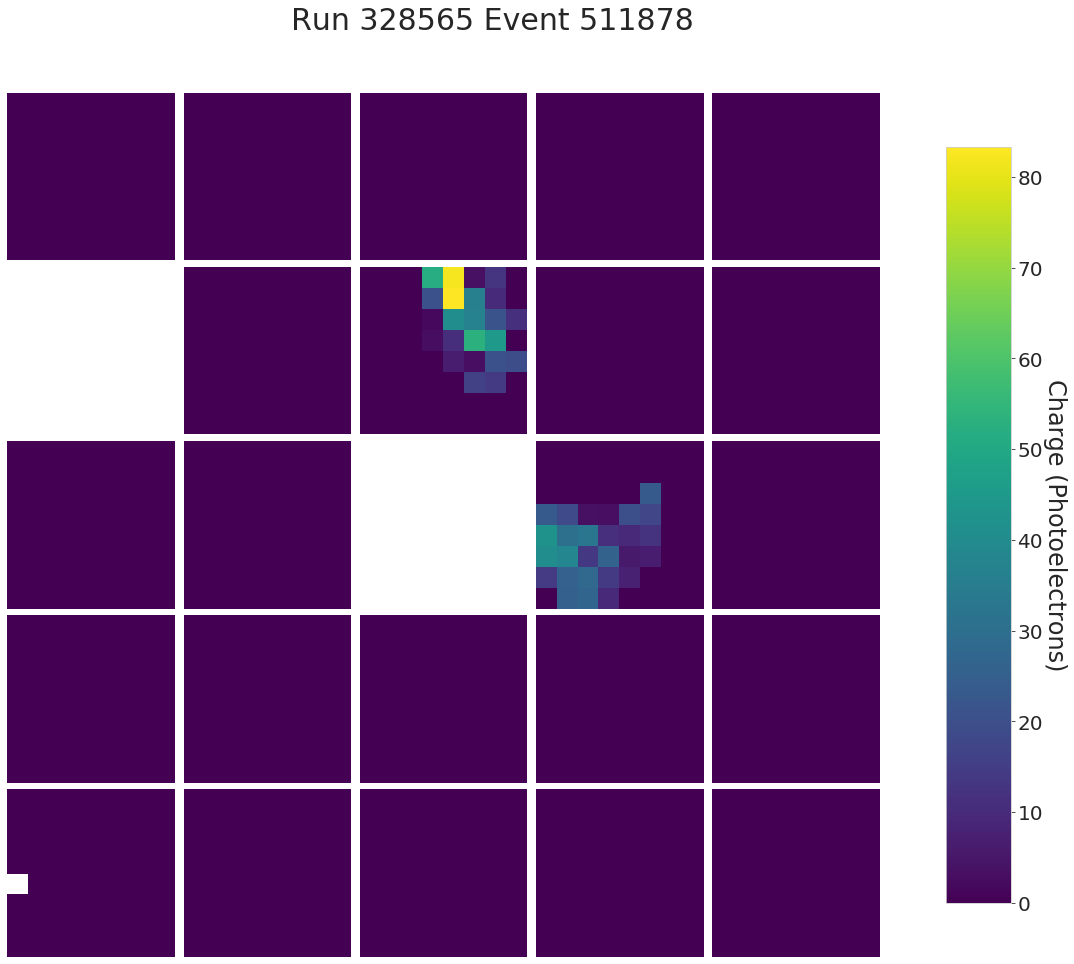

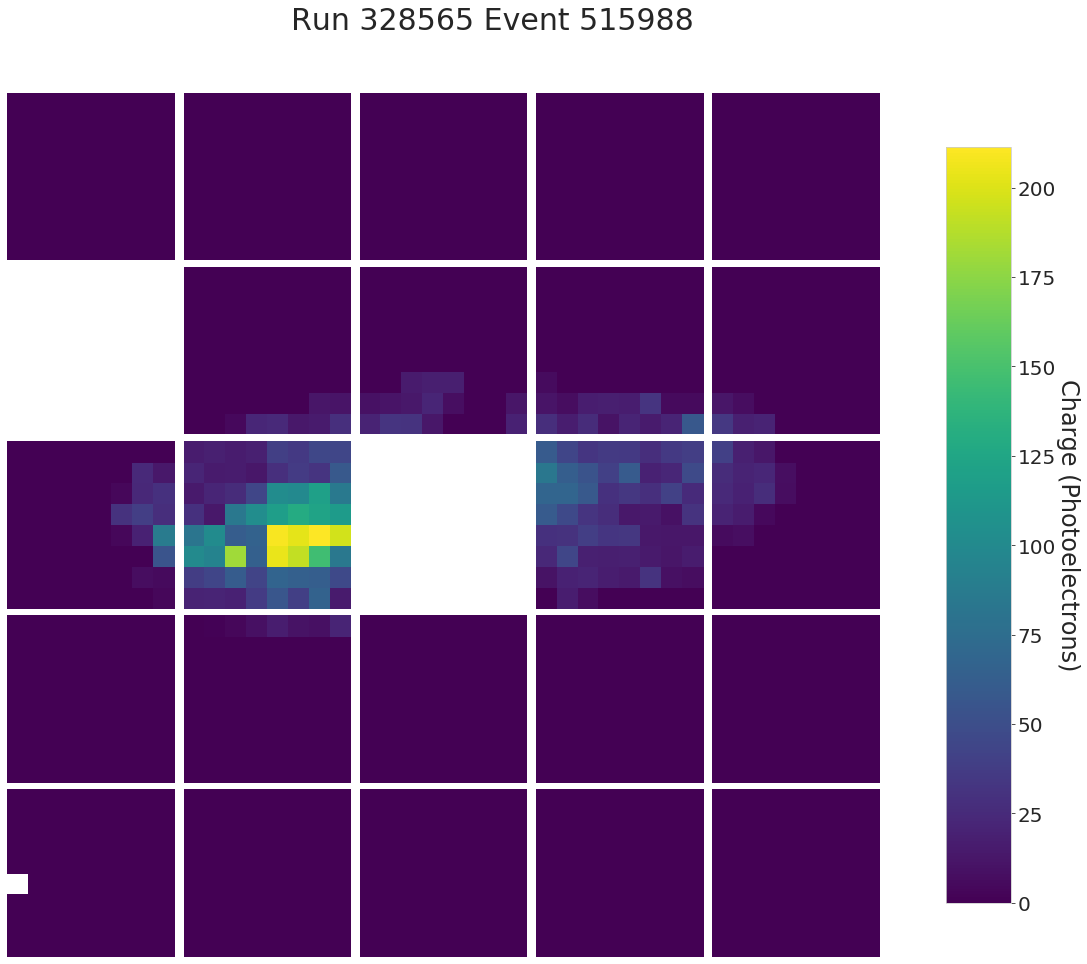

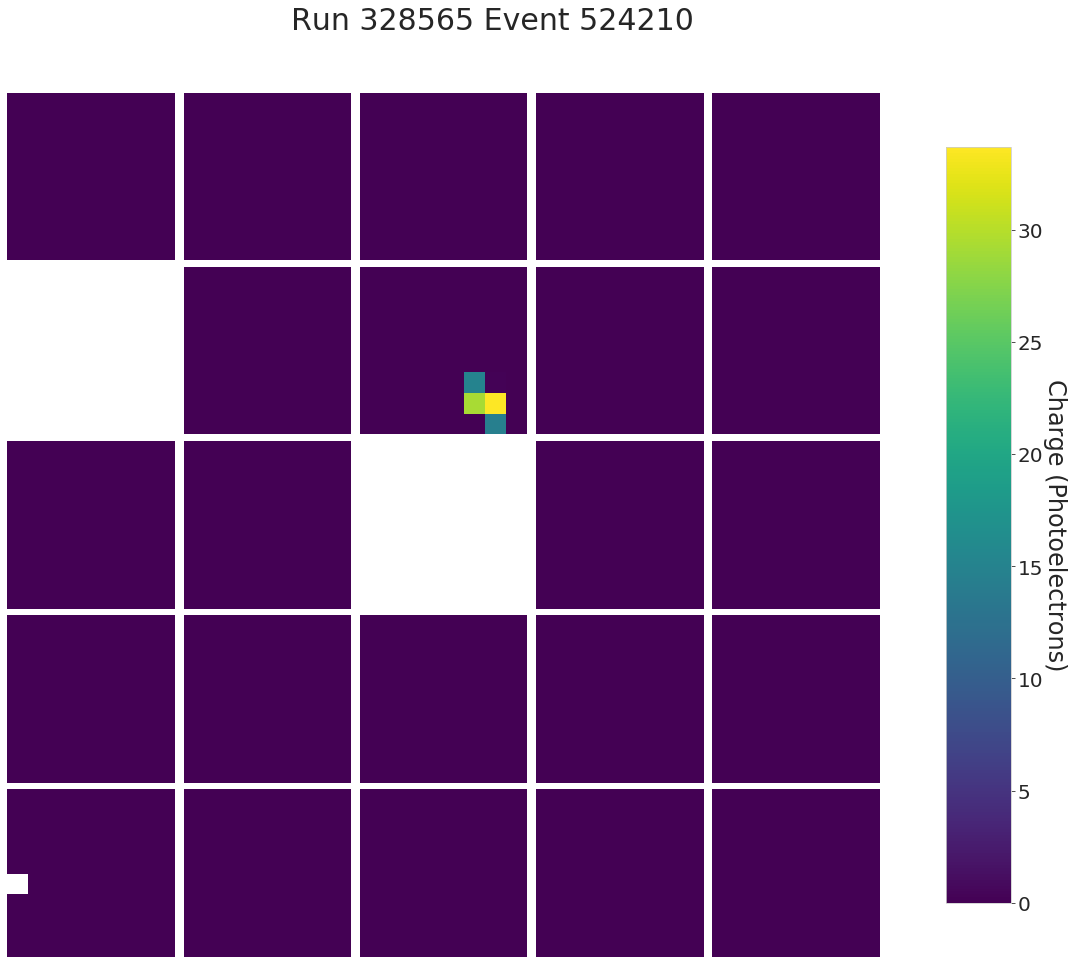

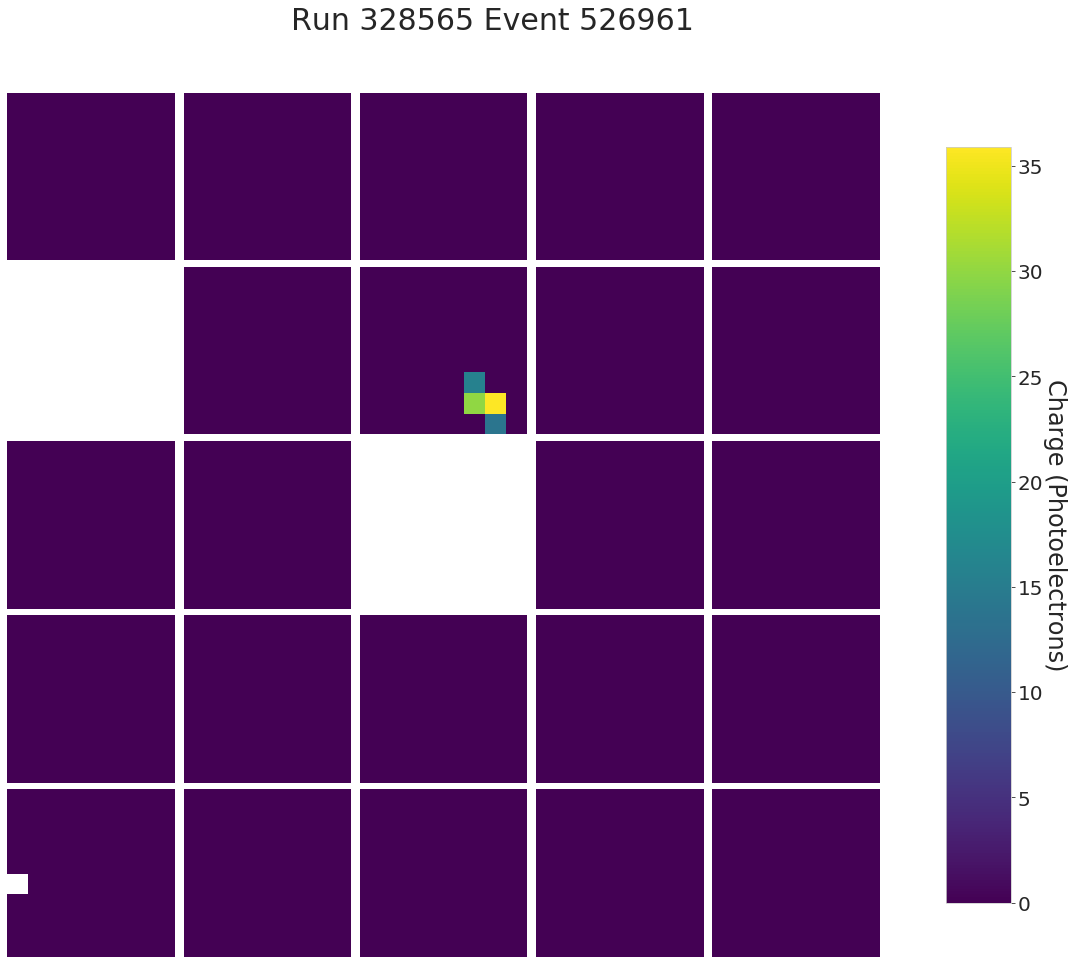

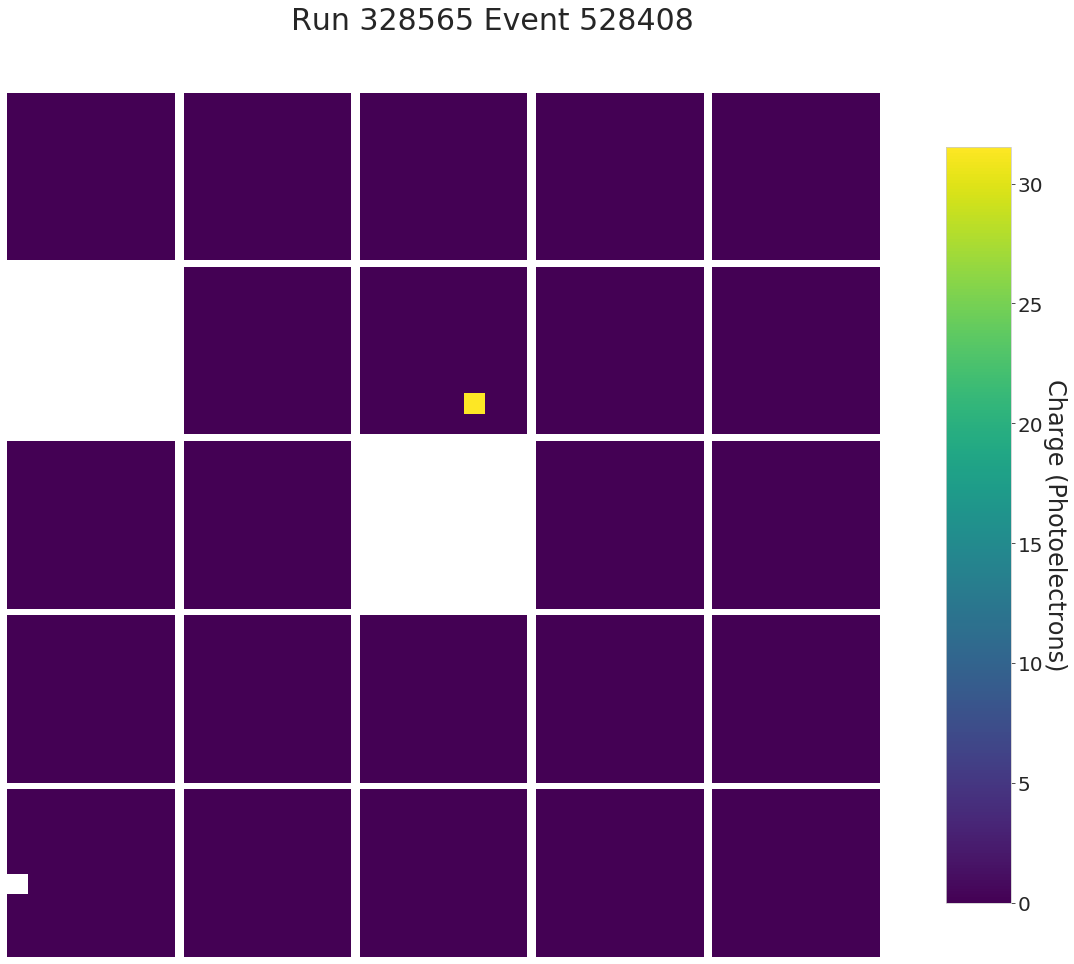

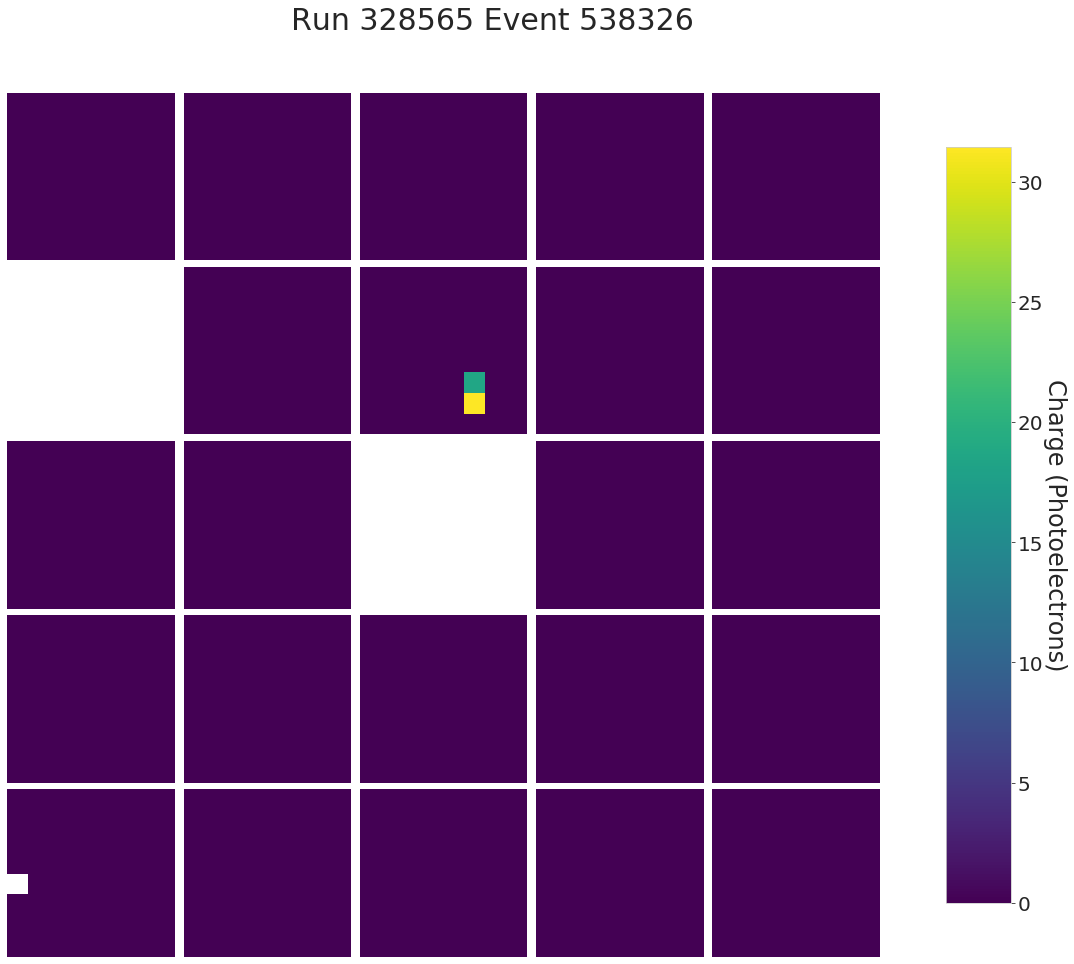

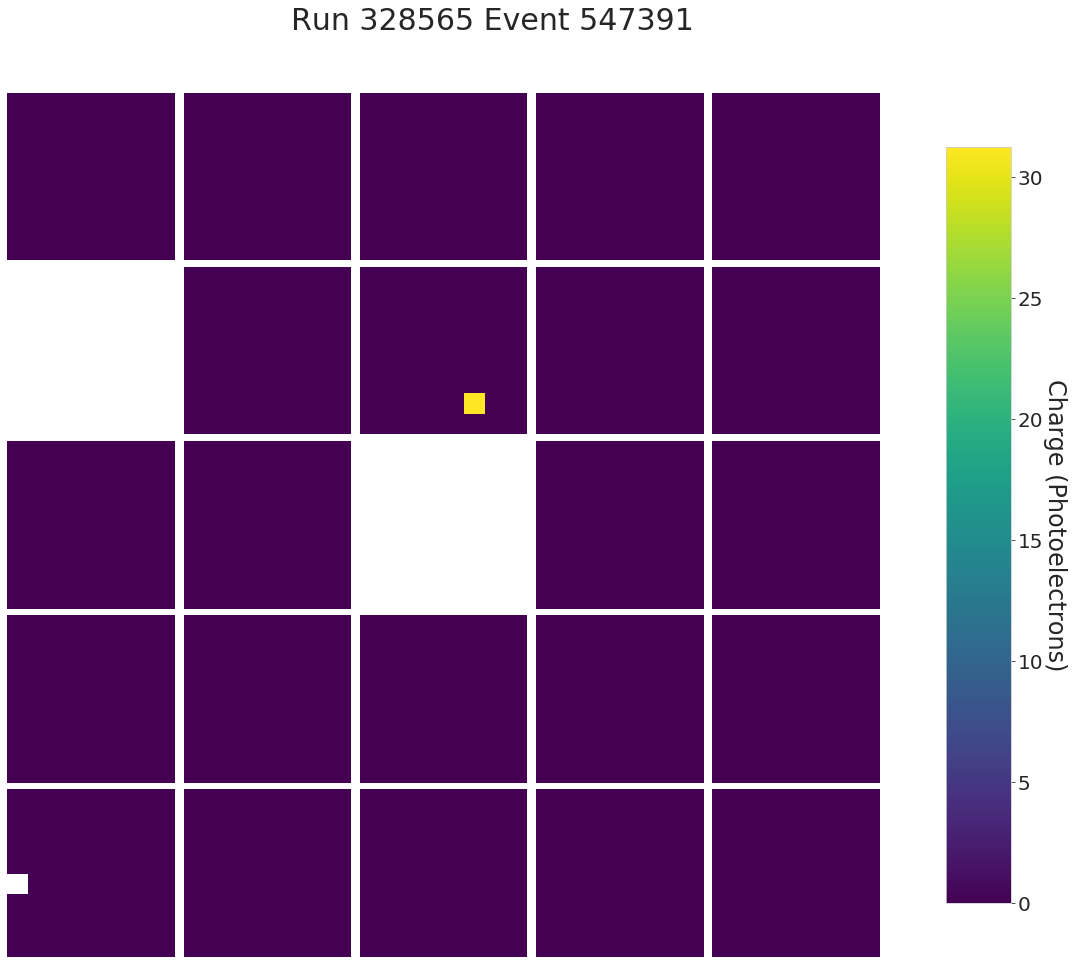

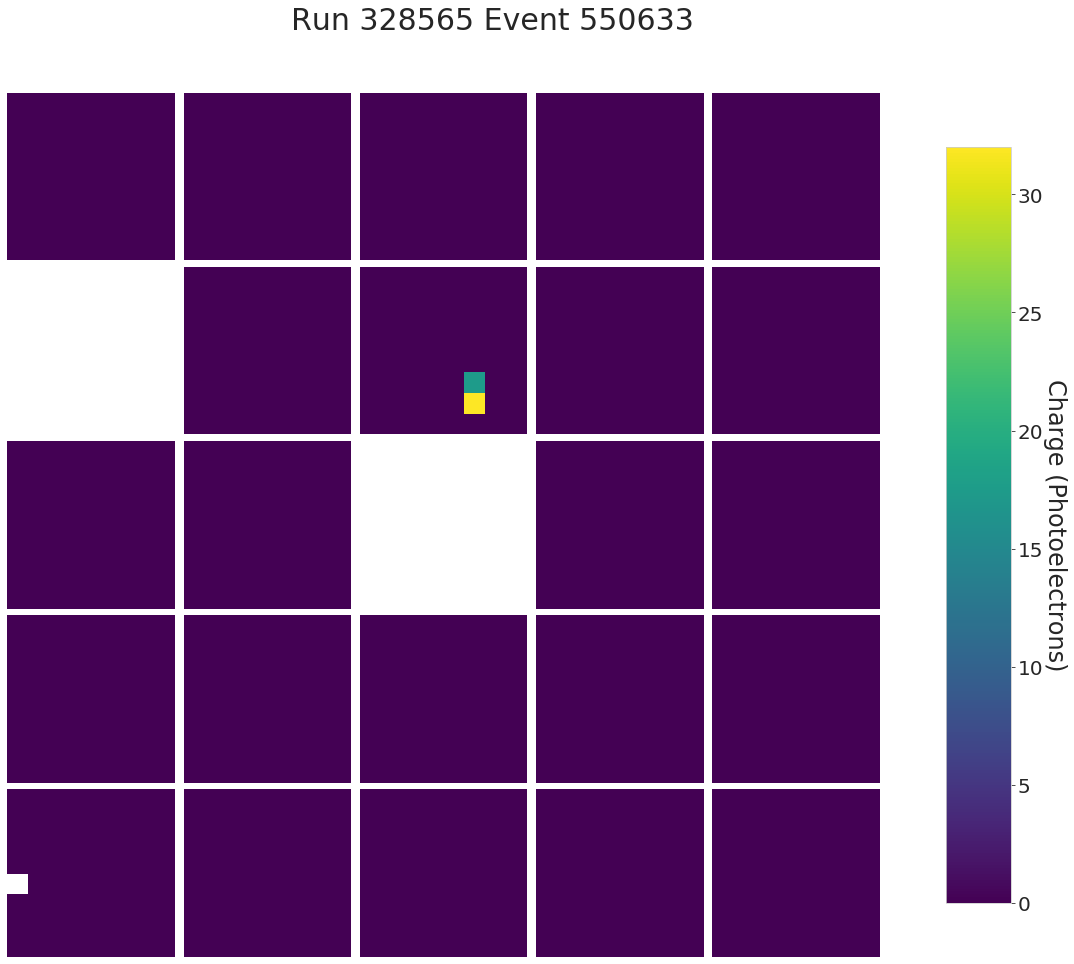

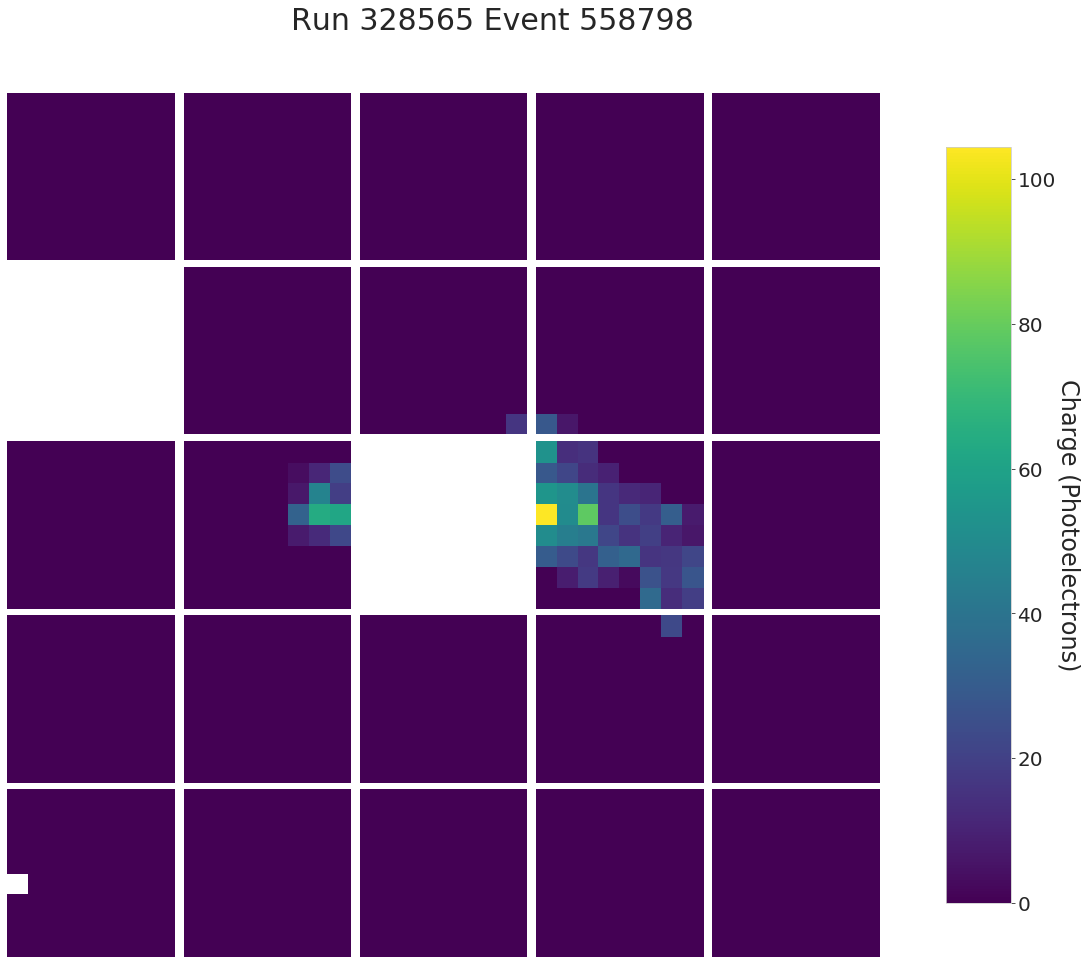

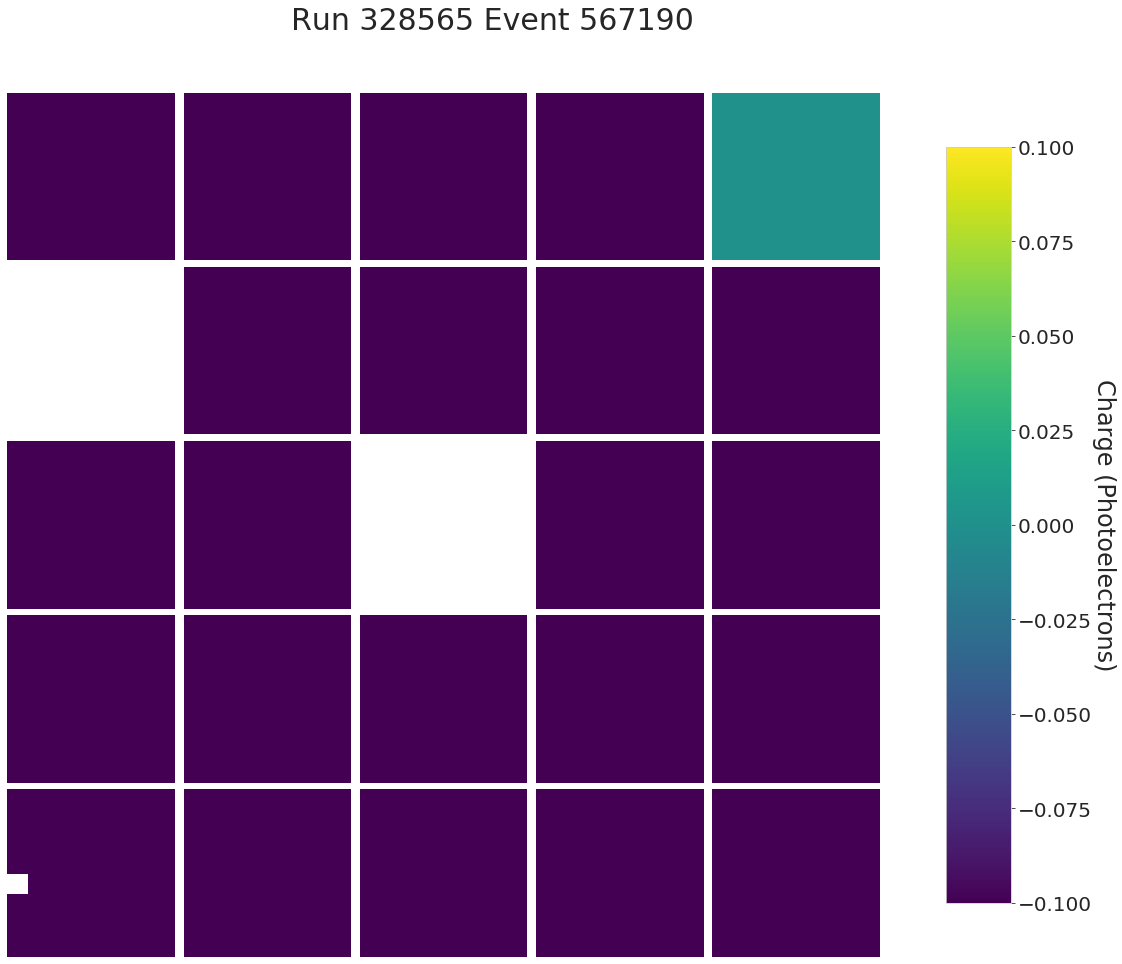

In [204]:
reader = target_io.WaveformArrayReader("/home/bmode/cam_data/cal328565.r1")
n_pixels = reader.fNPixels
n_samples = reader.fNSamples
noise_average = np.load("noise_averages.npz")["arr_0"]
waveforms = np.zeros((n_pixels, n_samples), dtype=np.float32)
for ev in [ev for r, ev in spike if int(r) == 328565][:10]:
    ev = int(ev)
    reader.GetR1Event(ev, waveforms)
    peak_position = np.argmax(waveforms, axis=1)
    charges = mcs.calculate_charge(waveforms, peak_position, n_samples)
    charges = apply_gains(charges)
    image = np.zeros((40, 40))
    for i, val in enumerate(charges):
        image[grid_ind[i] // 40, grid_ind[i] % 40] = val
    image = clean_image(charges, grid_ind, noise_average)
    camera_image(image, 328565, ev)
    plt.show()

In [294]:
gam_width = np.asarray(gam_width)
gam_length = np.asarray(gam_length)
gam_dis = np.asarray(gam_dis)
gam_size = np.asarray(gam_size)
gam_alpha = np.asarray(gam_alpha)
gam_events = np.asarray(gam_events)
for inter in np.linspace(-1.25, -1.01, 13):
    print(f"Intercept: {inter}")
    gam_cut = [i for i, val in enumerate(gam_width) if val < inter+0.7*np.log10(gam_size[i])
               and gam_length[i] < -5.3+3.0*np.log10(gam_size[i])
               and gam_size[i] > 250.
               and gam_size[i] < 20000.
               and gam_dis[i] < 17.
               and gam_dis[i] > 5.
               and gam_dis[i] < 19.0-11.0*(gam_width[i]/gam_length[i])
               and gam_dis[i] > 17.0-26.0*(gam_width[i]/gam_length[i])
               and np.degrees(gam_alpha[i]) < 12.]
    print(f"Gammas: {len(gam_cut)}")
    cut = [i for i, val in enumerate(off_data["width"]) if val < inter+0.7*np.log10(off_data["size"][i]) 
           and off_data["length"][i] < -5.3+3.0*np.log10(off_data["size"][i]) 
           and off_data["size"][i] > 250.
           and off_data["size"][i] < 20000.
           and off_data["dis"][i] < 17.
           and off_data["dis"][i] > 5.
           and off_data["dis"][i] < 19.0-11.0*(off_data["width"][i]/off_data["length"][i])
           and off_data["dis"][i] > 17.0-26.0*(off_data["width"][i]/off_data["length"][i])
           and np.degrees(off_data["alpha"][i]) < 12.]
    print(f"OFF: {len(cut)}")
    print(f"Li Ma Significance: {li_ma_sig(1, len(cut)+10*len(gam_cut), len(cut))}")
    print("\n")

Intercept: -1.25
Gammas: 6


/home/bmode/anaconda2/envs/python_3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10


OFF: 273
Li Ma Significance: 2.4393315110103986


Intercept: -1.23
Gammas: 6
OFF: 309
Li Ma Significance: 2.3057941835352795


Intercept: -1.21
Gammas: 7
OFF: 345
Li Ma Significance: 2.540967415781242


Intercept: -1.19
Gammas: 8
OFF: 403
Li Ma Significance: 2.689483935150263


Intercept: -1.17
Gammas: 10
OFF: 473
Li Ma Significance: 3.094324812401151


Intercept: -1.15
Gammas: 11
OFF: 553
Li Ma Significance: 3.1566237863321116


Intercept: -1.13
Gammas: 11
OFF: 638
Li Ma Significance: 2.9562386309900517


Intercept: -1.1099999999999999
Gammas: 11
OFF: 737
Li Ma Significance: 2.764966647097429


Intercept: -1.09
Gammas: 14
OFF: 838
Li Ma Significance: 3.2868933533317803


Intercept: -1.07
Gammas: 15
OFF: 940
Li Ma Significance: 3.3307434741904074


Intercept: -1.05
Gammas: 17
OFF: 1065
Li Ma Significance: 3.5463619930120593


Intercept: -1.03
Gammas: 17
OFF: 1193
Li Ma Significance: 3.3637895490023477


Intercept: -1.01
Gammas: 17
OFF: 1310
Li Ma Significance: 3.21944748211122




In [289]:
print(np.linspace(-1.25, -1.01, 13))

[-1.25 -1.23 -1.21 -1.19 -1.17 -1.15 -1.13 -1.11 -1.09 -1.07 -1.05 -1.03
 -1.01]


In [16]:
runs = {328555: "on", 328557: "allon", 328564: "off", 
        328565: "on", 328567: "on", 328569: "off", 328572: "off", 
        328573: "on", 328574: "on", 328581: "off", 328583: "off",
        328585: "on", 328592: "off", 328597: "off", 328599: "on",
        328606: "off", 328608: "on", 328610: "on", 328615: "off",
        328617: "on", 328619: "on", 328627: "off", 328629: "allon",
        328630: "allon", 328631: "allon", 328640: "off", 328642: "on",
        328646: "on", 328700: "on", 328717: "off", 328719: "on",
        328732: "on", 328733: "on", 328748: "on", 328750: "on",
        328761: "on", 328763: "on", 328770: "on", 328772: "on",
        328781: "on", 328792: "on", 328794: "on", 328821: "on",
        328846: "on", 328854: "on", 328856: "on", 328865: "on",
        328867: "on"}
all_on_data = []
for r in runs.keys():
    if runs[r] != "allon":
        temp = np.loadtxt(f"{DATADIR}/on_data_run{r}.txt", skiprows=1, delimiter=", ")
        all_on_data.extend(temp)
all_on_data = np.asarray(all_on_data).T
        
on_data = {"run": all_on_data[0],
        "event": all_on_data[1],
        "tack": all_on_data[4],
        "size": all_on_data[5],
        "frac2": all_on_data[6],
        "x": all_on_data[7],
        "y": all_on_data[8],
        "width": all_on_data[9],
        "length": all_on_data[10],
        "dis": all_on_data[12],
        "alpha": all_on_data[14]}

In [9]:
livetimes = [1654, 1552, 3166, 1390, 1099, 1551, 1421, 1551, 1551, 1681, 1552, 1008, 1682, 1552, 1421, 1687,
             1552, 1421, 1551, 1421, 1552, 1682, 1552, 1682, 1421, 1552, 1682, 1551, 745, 1551, 1682, 1552,
             1682, 1682, 1551, 1551, 1552, 1682, 1682, 1552, 1420, 1682, 1552, 1682]

In [10]:
livetimes = np.asarray(livetimes, dtype=np.float32)
rate = []
error = []
big_total = 0
for i, r in enumerate([r for r in runs.keys() if runs[r] != "allon"]):
    on_num = len([i for i, val in enumerate(on_data["run"]) if int(val) == r])
    off_num = len([i for i, val in enumerate(off_data["run"]) if int(val) == r])
    total = on_num + off_num
    big_total += total
    rate.append(total / (2 * livetimes[i]))
    error.append(np.sqrt(total) / (2 * livetimes[i]))
print(big_total / (2 * np.sum(livetimes)))

2.096907321177307


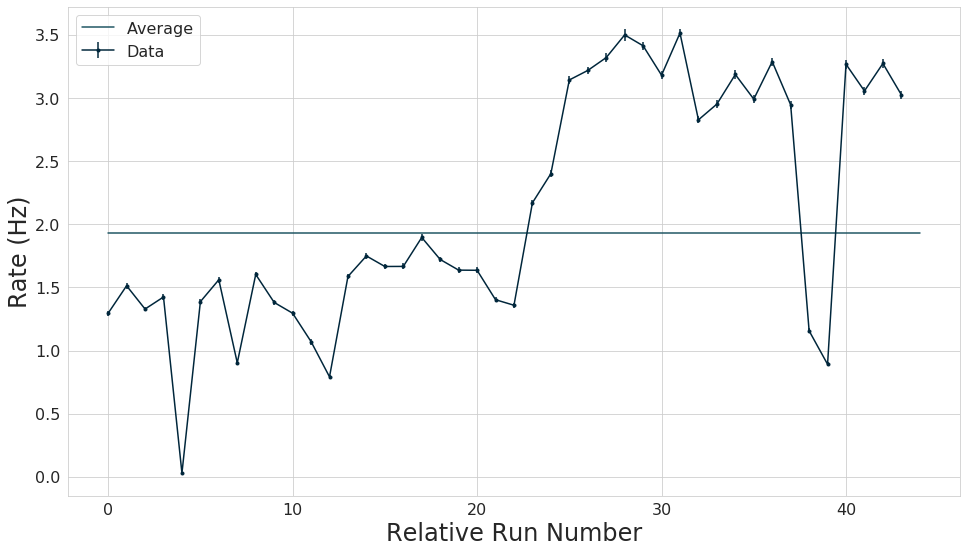

In [371]:
rate = np.asarray(rate)
error = np.asarray(error)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.errorbar(range(len(rate)), rate, yerr=error, marker=".", label="Data")
ax.plot([0, 44], [2.1, 2.1], label="Average")
ax.set_xlabel("Relative Run Number", fontsize=24)
ax.set_ylabel("Rate (Hz)", fontsize=24)
ax.tick_params(labelsize=16)
ax.legend(loc="upper left", fontsize=16)

In [11]:
on_rate = []
on_error = []
off_rate = []
off_error = []
on_big_total = 0
off_big_total = 0
for i, r in enumerate([r for r in runs.keys() if runs[r] != "allon"]):
    on_num = len([i for i, val in enumerate(on_data["run"]) if int(val) == r])
    off_num = len([i for i, val in enumerate(off_data["run"]) if int(val) == r])
    on_big_total += on_num
    off_big_total += off_num
    on_rate.append(on_num / (livetimes[i]))
    on_error.append(np.sqrt(on_num) / (livetimes[i]))
    off_rate.append(off_num / (livetimes[i]))
    off_error.append(np.sqrt(off_num) / (livetimes[i]))
on_avg = on_big_total / (np.sum(livetimes))
off_avg = off_big_total / (np.sum(livetimes))

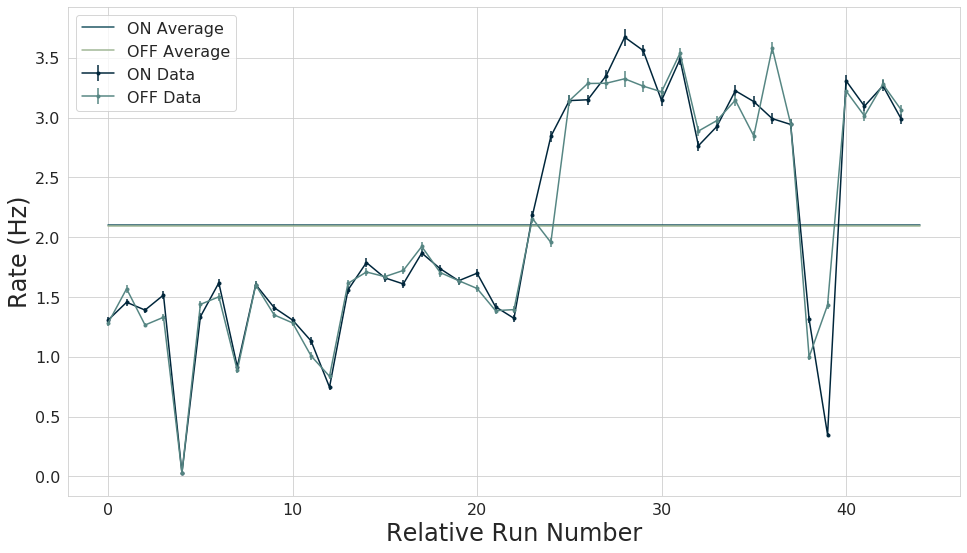

In [12]:
rate = np.asarray(rate)
error = np.asarray(error)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
ax.errorbar(range(len(rate)), on_rate, yerr=on_error, marker=".", label="ON Data")
ax.plot([0, 44], [on_avg, on_avg], label="ON Average")
ax.errorbar(range(len(rate)), off_rate, yerr=off_error, marker=".", label="OFF Data")
ax.plot([0, 44], [off_avg, off_avg], label="OFF Average")
ax.set_xlabel("Relative Run Number", fontsize=24)
ax.set_ylabel("Rate (Hz)", fontsize=24)
ax.tick_params(labelsize=16)
ax.legend(loc="upper left", fontsize=16)

/home/bmode/anaconda2/envs/python_3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.
/home/bmode/anaconda2/envs/python_3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


[192. 157. 147. 124. 109. 121. 105. 112.  95.  82. 103. 112. 101.  97.
 103.  97.  86. 104.  77. 107.  95.  93.  83.  84. 104.  97.  94.  97.
  85.  71.  80.  89.  88.  81.  88.  70.  98. 100.  80.  72.  95.  89.
  93.  94.  82.  70. 109.  82.  93.  92.  93.  82.  81.  84.  83.  90.
  89.  91.  98.  79.  72.  64.  76.  66.  72.  76. 100.  78.  74.  73.
  82.  58.  83.  90.  72.  70.  73.  77.  80.  78.  82.  69.  61.  81.
  68.  80.  67.  78.  65.  70.]
[ 83.  82.  98.  94.  99.  85.  86.  97.  85.  96.  84.  76.  95.  85.
  97. 103.  94. 101.  99.  97. 100. 101.  89. 101.  80.  78.  89.  85.
  85.  93.  85.  84. 105.  79.  89.  80.  99.  86.  85.  85.  76.  79.
  83. 111.  78.  76.  84.  78.  81. 102.  84. 104. 104.  87.  75. 110.
  80.  98.  79.  70.  87.  94.  78.  86.  74.  71.  91.  78.  71.  76.
  71.  73.  59.  65.  64.  63.  72.  86.  81.  73.  74.  70.  69.  60.
  79.  87.  79.  74.  81.  60.]
1.0002843332385556


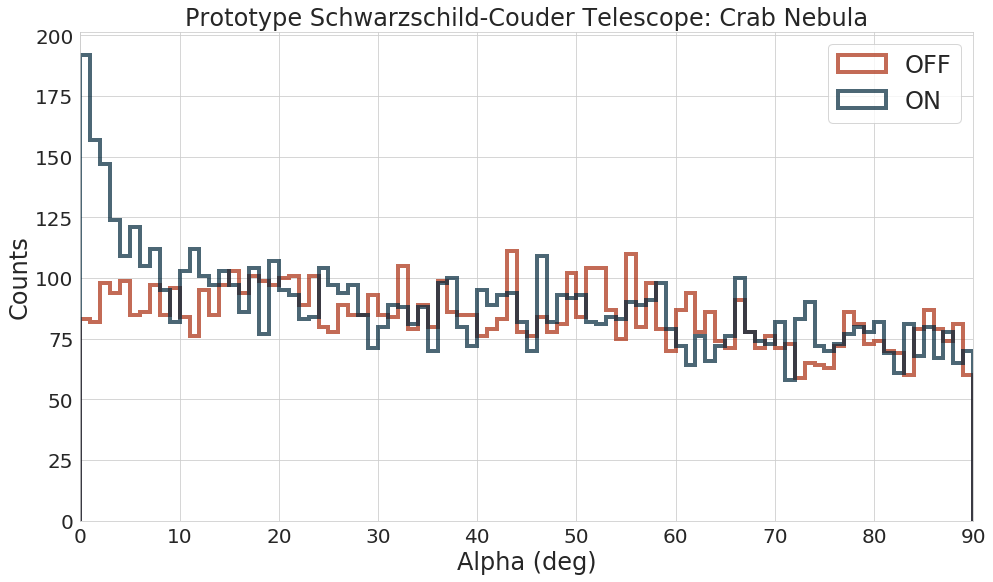

In [17]:
off_cut = [i for i, val in enumerate(off_data["width"]) if val < -1.05+0.7*np.log10(off_data["size"][i]) 
           and off_data["length"][i] < -5.3+3.0*np.log10(off_data["size"][i]) 
           and off_data["size"][i] > 250.
           and off_data["size"][i] < 20000.
           and off_data["dis"][i] < 17.
           and off_data["dis"][i] > 5.
           and off_data["dis"][i] < 19.0-11.0*(off_data["width"][i]/off_data["length"][i])
           and off_data["dis"][i] > 17.0-26.0*(off_data["width"][i]/off_data["length"][i])]
on_cut = [i for i, val in enumerate(on_data["width"]) if val < -1.05+0.7*np.log10(on_data["size"][i]) 
          and on_data["length"][i] < -5.3+3.0*np.log10(on_data["size"][i]) 
          and on_data["size"][i] > 250.
          and on_data["size"][i] < 20000.
          and on_data["dis"][i] < 17.
          and on_data["dis"][i] > 5.
          and on_data["dis"][i] < 19.0-11.0*(on_data["width"][i]/on_data["length"][i])
          and on_data["dis"][i] > 17.0-26.0*(on_data["width"][i]/on_data["length"][i])]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
off_bins, _, _ = ax.hist(np.degrees(off_data["alpha"][off_cut]), bins=90, range=(0, 90), color=palette[7], alpha=0.7, histtype="step", label="OFF", linewidth=4.0)
on_bins, _, _ = ax.hist(np.degrees(on_data["alpha"][on_cut]), bins=90, range=(0, 90), histtype="step", alpha=0.7, label="ON", linewidth=4.0)
ax.set_xlabel("Alpha (deg)", fontsize=24)
ax.set_ylabel("Counts", fontsize=24)
ax.legend(fontsize=24)
ax.set_xlim((0, 90))
ax.tick_params(labelsize=20)
ax.set_title("Prototype Schwarzschild-Couder Telescope: Crab Nebula", fontsize=24)
#ax.plot([6, 6], [0, 230], linewidth=4.0, linestyle="--", color="black")
print(on_bins)
print(off_bins)
r = np.sum(on_bins[20:60]) / np.sum(off_bins[20:60])
print(r)

In [14]:
N_off_loose = r * len([val for val in off_data["alpha"][off_cut] if np.degrees(val) <= 12.0])
N_on_loose = len([val for val in on_data["alpha"][on_cut] if np.degrees(val) <= 12.0])
N_off_tight = r * len([val for val in off_data["alpha"][off_cut] if np.degrees(val) <= 6.0])
N_on_tight = len([val for val in on_data["alpha"][on_cut] if np.degrees(val) <= 6.0])
alpha = 1.
print(f"Li-Ma Significance (Loose): {li_ma_sig(alpha, N_on_loose, N_off_loose)}")
print(f"Li-Ma Significance (Tight): {li_ma_sig(alpha, N_on_tight, N_off_tight)}")

Li-Ma Significance (Loose): 7.85197261452197
Li-Ma Significance (Tight): 8.315090018537374


In [342]:
print(N_on_loose)

891.0673281360738


In [346]:
li_ma_sig(1, 1008, 678)

8.062853868553521

In [15]:
print(r * len([val for val in off_data["alpha"][off_cut] if np.degrees(val) <= 12.0]))
print(len([val for val in on_data["alpha"][on_cut] if np.degrees(val) <= 12.0]))
print(r * len([val for val in off_data["alpha"][off_cut] if np.degrees(val) <= 6.0]))
print(len([val for val in on_data["alpha"][on_cut] if np.degrees(val) <= 6.0]))

1065.3028148990618
1459
541.1538242820586
850


In [374]:
1329.7 / 1.015

1310.049261083744

In [16]:
print(r * len([val for val in np.degrees(off_data["alpha"][off_cut]) if val <= 12.0]))
print(len([val for val in on_data["alpha"][on_cut] if np.degrees(val) <= 12.0]))
print(r * len([val for val in off_data["alpha"][off_cut] if np.degrees(val) <= 6.0]))
print(len([val for val in on_data["alpha"][on_cut] if np.degrees(val) <= 6.0]))

1065.3028148990618
1459
541.1538242820586
850


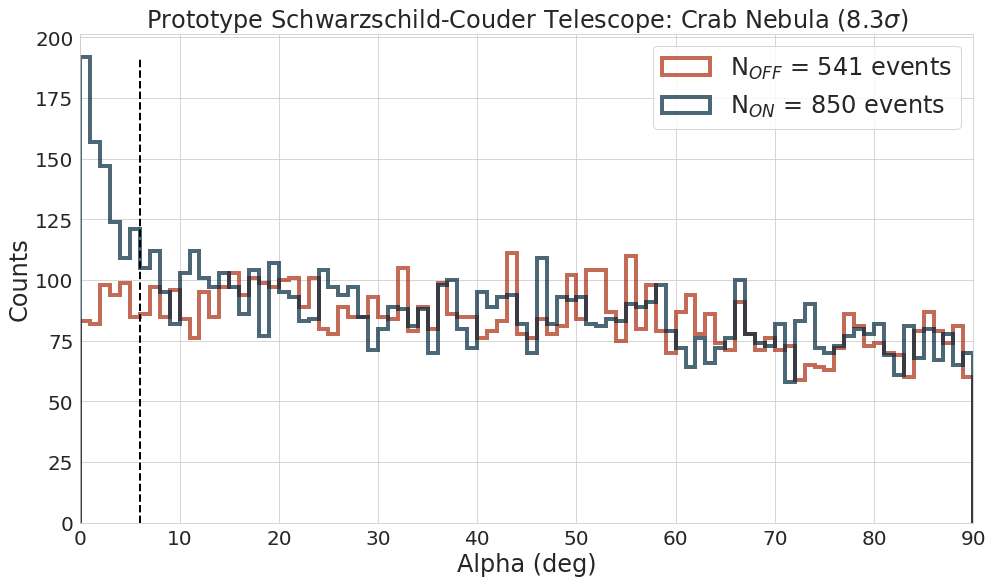

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
off_bins, _, _ = ax.hist(np.degrees(off_data["alpha"][off_cut]), bins=90, range=(0, 90), color=palette[7], alpha=0.7, histtype="step", label=r"N$_{OFF}$ = 541 events", linewidth=4.0)
on_bins, _, _ = ax.hist(np.degrees(on_data["alpha"][on_cut]), bins=90, range=(0, 90), histtype="step", alpha=0.7, label=r"N$_{ON}$ = 850 events", linewidth=4.0)
ax.set_xlabel("Alpha (deg)", fontsize=24)
ax.set_ylabel("Counts", fontsize=24)
ax.legend(fontsize=24)
ax.set_xlim((0, 90))
ax.tick_params(labelsize=20)
ax.set_title(r"Prototype Schwarzschild-Couder Telescope: Crab Nebula ($8.3\sigma$)", fontsize=24)
ax.plot([6, 6], [0, 192], linewidth=2.0, linestyle="--", color="black")

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
off_bins, _, _ = ax.hist(np.degrees(off_data["alpha"][off_cut]), bins=90, range=(0, 90), color=palette[0], alpha=0.7, histtype="step", label="OFF", linewidth=4.0)
on_bins, _, _ = ax.hist(np.degrees(on_data["alpha"][on_cut]), bins=90, range=(0, 90), color=palette[7], histtype="step", alpha=0.7, label="ON", linewidth=4.0)
ax.set_xlabel("Angle from air shower axis to Crab (degrees)", fontsize=24)
ax.set_ylabel("Counts", fontsize=24)
ax.legend(fontsize=24)
ax.set_xlim((0, 90))
ax.set_ylim((0, 200))
ax.tick_params(labelsize=20)
ax.text(30, 160, "Preliminary", fontsize=40, horizontalalignment="center", verticalalignment="center",
        color=palette[7], alpha=0.7)
ax.set_title("Prototype Schwarzschild-Couder Telescope: Crab Nebula", fontsize=24)
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')

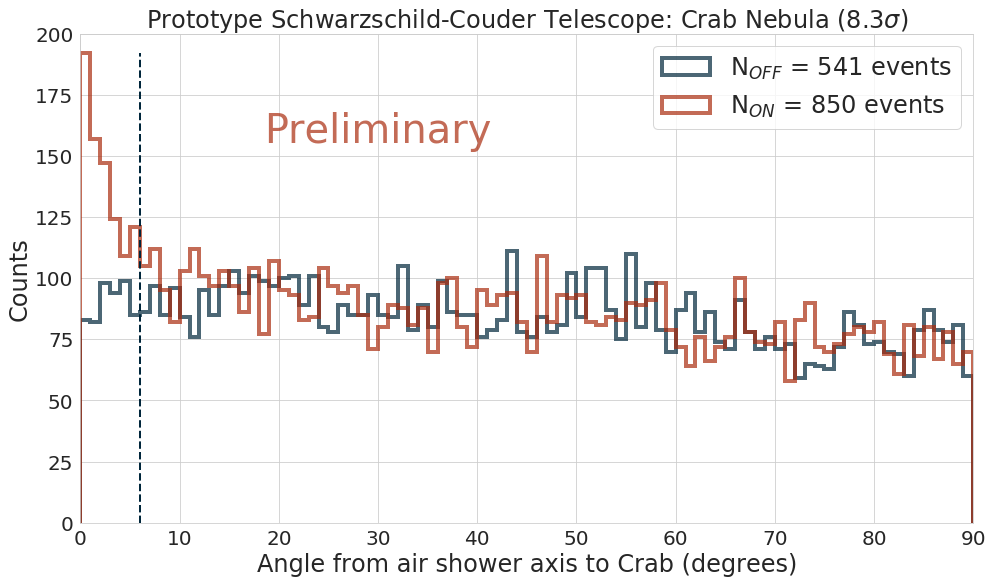

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))
off_bins, _, _ = ax.hist(np.degrees(off_data["alpha"][off_cut]), bins=90, range=(0, 90), color=palette[0], alpha=0.7, histtype="step", label=r"N$_{OFF}$ = 541 events", linewidth=4.0)
on_bins, _, _ = ax.hist(np.degrees(on_data["alpha"][on_cut]), bins=90, range=(0, 90), color=palette[7], histtype="step", alpha=0.7, label=r"N$_{ON}$ = 850 events", linewidth=4.0)
ax.set_xlabel("Angle from air shower axis to Crab (degrees)", fontsize=24)
ax.set_ylabel("Counts", fontsize=24)
ax.legend(fontsize=24)
ax.set_xlim((0, 90))
ax.tick_params(labelsize=20)
ax.text(30, 160, "Preliminary", fontsize=40, horizontalalignment="center", verticalalignment="center",
        color=palette[7], alpha=0.7)
ax.set_ylim((0, 200))
ax.set_title(r"Prototype Schwarzschild-Couder Telescope: Crab Nebula ($8.3\sigma$)", fontsize=24)
ax.plot([6, 6], [0, 192], linewidth=2.0, linestyle="--")

In [24]:
first_cut_cosrays = [i for i, val in enumerate(cos_width) if val < -1.05+0.7*np.log10(cos_size[i])
                     and cos_length[i] < -5.3+3.0*np.log10(cos_size[i])
                     and cos_size[i] > 250.
                     and cos_size[i] < 20000.
                     and cos_dis[i] < 17.
                     and cos_dis[i] > 5.
                     and cos_dis[i] < 19.-11.*(cos_width[i] / cos_length[i]) 
                     and cos_dis[i] > 17.-26.*(cos_width[i] / cos_length[i])]
first_cut_gammas = [i for i, val in enumerate(gam_width) if val < -1.05+0.7*np.log10(gam_size[i]) 
                    and gam_length[i] < -5.3+3.0*np.log10(gam_size[i]) 
                    and gam_size[i] > 250.
                    and gam_size[i] < 20000.
                    and gam_dis[i] < 17.
                    and gam_dis[i] > 5.
                    and gam_dis[i] < 19.-11.*(gam_width[i] / gam_length[i])
                    and gam_dis[i] > 17.-26.*(gam_width[i] / gam_length[i])]
off_cut = [i for i, val in enumerate(off_data["width"]) if val < -1.05+0.7*np.log10(off_data["size"][i])
           and off_data["length"][i] < -5.3+3.0*np.log10(off_data["size"][i]) 
           and off_data["size"][i] > 250.
           and off_data["size"][i] < 20000.
           and off_data["dis"][i] < 17.
           and off_data["dis"][i] > 5.
           and off_data["dis"][i] < 19.0-11.0*(off_data["width"][i]/off_data["length"][i])
           and off_data["dis"][i] > 17.0-26.0*(off_data["width"][i]/off_data["length"][i])]

print(f"Cosmic Rays: {len(first_cut_cosrays)}")
print(f"Gamma Rays: {len(first_cut_gammas)}")
print(f"OFF: {len(off_cut)}")

/home/bmode/anaconda2/envs/python_3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10


Cosmic Rays: 381
Gamma Rays: 17
OFF: 7599


In [11]:
on_cut = [i for i, val in enumerate(on_data["width"]) if val < -1.05+0.7*np.log10(on_data["size"][i])
           and on_data["length"][i] < -5.3+3.0*np.log10(on_data["size"][i]) 
           and on_data["size"][i] > 250.
           and on_data["size"][i] < 20000.
           and on_data["dis"][i] < 17.
           and on_data["dis"][i] > 5.
           and on_data["dis"][i] < 19.0-11.0*(on_data["width"][i]/on_data["length"][i])
           and on_data["dis"][i] > 17.0-26.0*(on_data["width"][i]/on_data["length"][i])]
print(f"ON: {len(on_cut)}")

/home/bmode/anaconda2/envs/python_3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


ON: 7984
